In [2]:
import loompy
import os
import glob
import numpy as np
import os
import sys
import pybedtools
from pybedtools import BedTool
import collections
import csv
import pandas as pd
import matplotlib.pyplot as plt
import loompy
import scipy.sparse as sparse
import json
import logging
import pickle
import glob
import gc
import multiprocessing as mp
import numpy as np

from chromograph.pipeline import config
from chromograph.preprocessing.utils import *
from chromograph.features.feature_count import *
from chromograph.preprocessing.doublet_finder import doublet_finder
from chromograph.RNA.utils import rna_barcodes_to_atac

In [2]:
from umap import UMAP
from cytograph.metrics import jensen_shannon_distance
from cytograph.embedding import art_of_tsne

In [111]:
with loompy.connect('/proj/DEV_ATAC/Wheel_plots/Embryo_20220415/20220328_Embryo_imputed.loom') as ds:
    print(ds.ca.keys())
    ds.ca.Embedding = ds.ca.UMAP
    

['Age', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'CellCycle', 'CellCycle_G1', 'CellCycle_G2M', 'CellCycle_S', 'CellID', 'Chemistry', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Clusters_peaks', 'Clusters_renumbered', 'Cmobarcodes', 'Comment', 'Datecaptured', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'FRIP', 'FRtss', 'Id', 'IsCycling', 'LSI', 'LSI_b', 'Label', 'Method', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'Plugdate', 'Project', 'PseudoAge', 'Roi', 'SEX', 'Sampleok', 'Sex', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSNE_bin', 'TSS_fragments', 'Tissue', 'TotalUMI', 'Transcriptome', 'UMAP', 'UMAP3D', 'UMAP3D_bin', 'UMAP_bin', 'Y', 'barcode', 'chimeric', 'duplicate', 'excluded_reason', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'passed_filters', 'peak_region_cutsites', 'peak_region_fragments', 'preClusters', 'total', 'unmapped']


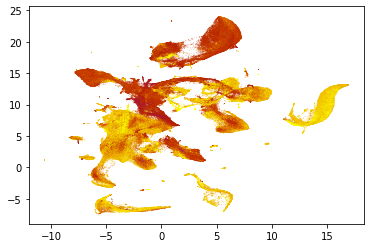

In [115]:
with loompy.connect('/proj/DEV_ATAC/Wheel_plots/Embryo_20220415/20220328_Embryo_imputed.loom') as ds:
    pos = ds.ca.UMAP
    plt.scatter(pos[:,0], pos[:,1], c=ds.ca.PseudoAge, cmap='gnuplot', lw=0, s=1, marker='.')

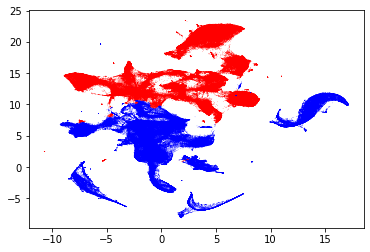

In [49]:
from scipy.cluster.hierarchy import cut_tree

with loompy.connect('/proj/DEV_ATAC/Build_20220328_samplecor/All/All_peaks.agg.loom') as dsout:
    cls = dsout.ca.Clusters
    branch = cut_tree(Z, 2).T[0]
    clusters = branch[cls]
    cls2split = {k:v for k,v in zip(cls, clusters)}
    
with loompy.connect('/proj/DEV_ATAC/Build_20220328_samplecor/All/All_peaks.loom') as ds:
    color = ['blue' if cls2split[x] else 'red' for x in ds.ca.Clusters]
    plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], lw=0, s=1, marker='.', c=color)

In [69]:
with loompy.connect('/proj/DEV_ATAC/Build_20220328_samplecor/All/All_peaks2.loom') as ds:
    print(ds.ca.keys())
    x = np.where(ds.ca.NPeaks==np.min(ds.ca.NPeaks))
    
    print(ds.ca.CellID[x])

['Age', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'CellID', 'Chemistry', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Cmobarcodes', 'Comment', 'Datecaptured', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'FRIP', 'FRtss', 'Id', 'LSI', 'LSI_b', 'Label', 'Method', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'Plugdate', 'Project', 'PseudoAge', 'Roi', 'SEX', 'Sampleok', 'Sex', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSNE_bin', 'TSS_fragments', 'Tissue', 'Transcriptome', 'UMAP', 'UMAP3D', 'UMAP3D_bin', 'UMAP_bin', 'Y', 'barcode', 'chimeric', 'duplicate', 'excluded_reason', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'passed_filters', 'peak_region_cutsites', 'peak_region_fragments', 'preClusters', 'total', 'unmapped']
['10X279_1:ACTATTCCATCCGTGG']


In [71]:
from chromograph.preprocessing.utils import *

chromosomes = get_chrom_sizes('GRCh38') 

tbx = pysam.Tabixfile('/data/proj/chromium/10X279_1_ABC_1/outs/fragments.tsv.gz')

present = set()
for row in tbx.fetch(parser=pysam.asBed()):
    if row[0] not in present:
        present.add(row[0])
present = [x for x in present if x in chromosomes.keys()]

14:22:48 INFO     Loaded chromosome sizes for GRCh38


In [80]:
cell = 'ACTATTCCATCCGTGG-1'
f = f'/datb/sl/camiel/scATAC/samples/10X279_1/fragments/{cell}.tsv.gz'
output = []

for chr in sorted(present):
    print(chr)
    for row in tbx.fetch(chr, parser=pysam.asBed()):
        if row[3] == cell:
            output.append(row[:3])
            
BedTool(output).remove_invalid().saveas(f)

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrX
chrY


<BedTool(/datb/sl/camiel/scATAC/samples/10X279_1/fragments/ACTATTCCATCCGTGG-1.tsv.gz)>

In [81]:
bd = BedTool(f)
bd.head()

chr1	28948	29340
 chr1	778679	778751
 chr1	940195	940245
 chr1	943272	943398
 chr1	1001357	1001705
 chr1	1116429	1116485
 chr1	1121315	1121539
 chr1	1399496	1399563
 chr1	1653442	1653629
 chr1	1659067	1659189
 

In [76]:
output

[]

In [55]:
with loompy.connect('/proj/DEV_ATAC/Build_20220318/All/All_peaks.loom') as ds:
    loom_file = ds.filename
    subset = loom_file.split('/')[-1].split('_')[0]
    print(subset)

All


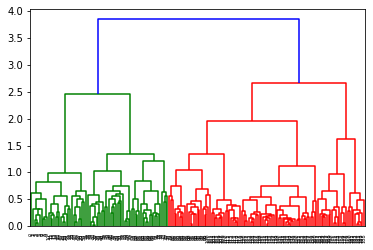

In [5]:
with loompy.connect('/proj/DEV_ATAC/Build_20220328_samplecor/All/All_peaks.agg.loom') as dsout:
    dendrogram(dsout.attrs.linkage)

In [22]:
with loompy.connect('/proj/DEV_ATAC/Build_20220318/All/All_peaks.loom') as ds:
    samples = np.array(['_'.join([a,b]) for a,b in zip(ds.ca.Shortname, ds.ca.Tissue)])
    
    print(f'Total cells: {ds.shape[1]}')
    print(f'Total donors: {len(np.unique(ds.ca.Shortname))}')
    print(f'Total samples: {len(np.unique(samples))}')
    print(f"Percentage Multiome cells: {100 * (np.sum(ds.ca.Chemistry=='multiome_atac')/ds.shape[1])}")

Total cells: 488935
Total donors: 23
Total samples: 62
Percentage Multiome cells: 29.35625389878


In [14]:
import logging
from typing import List

import numpy as np
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
from scipy import sparse

import loompy

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

class FeatureSelectionByMultilevelEnrichment:
    """
    Find markers at each of several levels relative to cluster labels
    """
    def __init__(self, n_clusters_per_level: List[int] = None, n_markers_per_cluster: int = 10, labels_attr: str = "Clusters", mask: np.ndarray = None, layer:str='') -> None:
        """
        Args:
            n_clusters_per_level		Desired number of clusters at each levels above the leaves, which determines where the tree is cut
            n_markers_per_cluster		Number of markers to include per cluster
        """
        self.n_clusters_per_level = n_clusters_per_level
        self.n_markers_per_cluster = n_markers_per_cluster
        self.labels_attr = labels_attr
        self.mask = mask
        self.valid_genes: np.ndarray = None
        self.enrichment: np.ndarray = None
        self.layer = layer

    def fit(self, ds: loompy.LoomConnection, labels: np.ndarray = None) -> np.ndarray:
        """
        Finds n_markers genes per cluster using enrichment score, at each of several levels

        Args:
            ds (LoomConnection):	Dataset
            labels					Optional labels to use instead of the cluster labels

        Returns:
            ndarray of selected marker genes (array of ints), shape (n_markers)
            ndarray of enrichment scores for the leaf level only, shape (n_genes, n_labels)
        """
        n_genes, n_cells = ds.shape

        # Find the cluster labels
        if labels is None:
            labels = ds.ca[self.labels_attr]
        n_labels = len(np.unique(labels))
        logging.info(f"Multilevel marker selection with {n_labels} clusters at the leaf level")

        # Find a good set of levels
        if self.n_clusters_per_level is None:
            proposal = np.array([25, 10, 5, 2])
            proposal = proposal[proposal < n_labels // 2]
            self.n_clusters_per_level = list(proposal)
        n_levels = len(self.n_clusters_per_level)
        if n_levels > 0:
            logging.info(f"Analyzing {n_levels} higher level{'s' if n_levels > 1 else ''} with {self.n_clusters_per_level} clusters")
            multilevel_markers = np.zeros((ds.shape[0], n_levels))

            # Find markers at the leaf level
            (all_markers, all_enrichment, means) = self._fit(ds, labels)
            logging.info(f"Found {all_markers.sum()} marker genes at level 0 (leaves)")
            
            # Agglomerative clustering
            data = np.log(means + 1)[all_markers, :].T
            D = pdist(data, 'correlation')
                        
            Z = hc.linkage(D, 'ward', optimal_ordering=True)
            old_labels_per_cluster = hc.leaves_list(Z)
            old_labels_per_cell = labels.copy()

            # Select markers at each level
            i = 0
            while i < n_levels:
                new_labels_per_cluster = hc.cut_tree(Z, n_clusters=self.n_clusters_per_level[i])
                temp = np.zeros_like(labels)
                for lbl in np.unique(old_labels_per_cluster):
                    temp[old_labels_per_cell == lbl] = new_labels_per_cluster[old_labels_per_cluster == lbl][0]
                labels = temp
                (markers, enrichment, _) = self._fit(ds, labels)
                logging.info(f"Found {markers.sum()} marker genes at level {i + 1}")
                logging.debug(ds.ra.Gene[markers])
                multilevel_markers[markers, i] = 1
                all_markers = (all_markers | markers)
                i += 1
            ds.ra.MultilevelMarkers = multilevel_markers
        else:
            logging.info("Not enough clusters for multilevel marker selection (using level 0 markers only)")
            # Find markers at the leaf level
            (all_markers, all_enrichment, means) = self._fit(ds, labels)
            logging.info(f"Found {all_markers.sum()} marker genes at level 0 (leaves)")

        self.enrichment = all_enrichment
        selected = np.zeros(ds.shape[0], dtype=bool)
        selected[np.where(all_markers)[0]] = True
        return selected

    def select(self, ds: loompy.LoomConnection) -> np.ndarray:
        selected = self.fit(ds)
        ds.ra.Selected = selected.astype("int")
        return selected

    def _fit(self, ds: loompy.LoomConnection, labels: np.ndarray) -> np.ndarray:
        logging.info("Computing enrichment statistic")
        n_labels = len(np.unique(labels))
        n_genes, n_cells = ds.shape

        # reorder matrix
        mtx = ds[self.layer].sparse().tocsr()
        ordering = np.argsort(labels)
        arr_list = []
        chunksize = 100000000 // mtx.shape[1]
        start = 0
        while start < mtx.shape[0]:
            submatrix = mtx[start:start + chunksize, :]
            arr_list.append(submatrix[:, ordering])
            start = start + chunksize
        mtx = sparse.vstack(arr_list)

        # split matrix on label indices
        ix = [np.where(np.sort(labels) == x)[0][0] for x in range(n_labels)] + [n_cells]
        arr_list = []
        for i in range(len(ix) - 1):
            arr_list.append(mtx[:, ix[i]:ix[i + 1]])

        # Number of cells per cluster
        sizes = np.zeros(n_labels)
        # Number of nonzero values per cluster
        nnz = np.zeros((ds.shape[0], n_labels))
        # Mean value per cluster
        means = np.zeros((ds.shape[0], n_labels))

        for i, arr in enumerate(arr_list):
            nnz[:, i] = arr.getnnz(axis=1)
            means[:, i] = np.squeeze((arr.mean(axis=1).A))
            sizes[i] = arr.shape[1]

        # Non-zeros and means over all cells
        mtx = sparse.hstack(arr_list)
        nnz_overall = mtx.getnnz(axis=1)
        means_overall = np.squeeze((mtx.mean(axis=1).A))

        # Scale by number of cells
        n_cells = mtx.shape[1]
        f_nnz = nnz / sizes
        f_nnz_overall = nnz_overall / n_cells

        # Means and fraction non-zero values in other clusters (per cluster)
        means_other = ((means_overall * n_cells)[None].T - (means * sizes)) / (n_cells - sizes)
        f_nnz_other = ((f_nnz_overall * n_cells)[None].T - (f_nnz * sizes)) / (n_cells - sizes)

        # enrichment = (f_nnz + 0.1) / (f_nnz_overall[None].T + 0.1) * (means + 0.01) / (means_overall[None].T + 0.01)
        enrichment = (f_nnz + 0.1) / (f_nnz_other + 0.1) * (means + 0.01) / (means_other + 0.01)

        # Select best markers
        if self.valid_genes is None:
            logging.info("Identifying valid genes")
            if "Valid" in ds.ra:
                self.valid_genes = ds.ra.Valid == 1
            else:
                nnz = ds.map([np.count_nonzero], axis=0)[0]
                self.valid_genes = np.logical_and(nnz > 10, nnz < ds.shape[1] * 0.6)

        if self.mask is None:
            excluded = set(np.where(~self.valid_genes)[0])
        else:
            excluded = set(np.where(((~self.valid_genes) | self.mask))[0])

        # Handle datasets with thousands of clusters	
        if n_genes - len(excluded) < self.n_markers_per_cluster * n_labels:
            included = self.valid_genes & ~self.mask
            return (included, enrichment, means)

        included = np.zeros(n_genes, dtype=bool)
        for ix in range(n_labels):
            enriched = np.argsort(enrichment[:, ix])[::-1]
            n = 0
            count = 0
            while count < self.n_markers_per_cluster:
                if enriched[n] in excluded:
                    n += 1
                    continue
                included[enriched[n]] = True
                excluded.add(enriched[n])
                n += 1
                count += 1
        return (included, enrichment, means)

from cytograph.species import Species
with loompy.connect('/proj/DEV_ATAC/Build_20220131/All/All_RNA_imputed.agg.loom') as dsout:
    with loompy.connect('/proj/DEV_ATAC/Build_20220131/All/All_RNA_imputed.loom') as ds:
        logging.info("Computing cluster gene enrichment scores")
        fe = FeatureSelectionByMultilevelEnrichment(mask=Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt")), layer='pooled')
#         all_markers, all_enrichment, means = fe.fit(ds)
        markers = fe.fit(ds)
        dsout['enrichment'] = fe.enrichment

15:13:48 INFO     Computing cluster gene enrichment scores
15:13:49 INFO     Multilevel marker selection with 240 clusters at the leaf level
15:13:49 INFO     Analyzing 4 higher levels with [25, 10, 5, 2] clusters
15:13:49 INFO     Computing enrichment statistic
15:24:51 INFO     Identifying valid genes
15:29:46 INFO     Found 2400 marker genes at level 0 (leaves)
15:29:47 INFO     Computing enrichment statistic
15:38:13 INFO     Found 250 marker genes at level 1
15:38:14 INFO     Computing enrichment statistic
15:46:45 INFO     Found 100 marker genes at level 2
15:46:45 INFO     Computing enrichment statistic
15:54:55 INFO     Found 50 marker genes at level 3
15:54:55 INFO     Computing enrichment statistic
16:03:22 INFO     Found 20 marker genes at level 4


In [89]:
from chromograph.RNA.RNA_analysis import RNA_analysis

peak_file = '/proj/DEV_ATAC/Build_20220131/Purk_2/Purk_2_peaks.loom'
subset_dir = '/proj/DEV_ATAC/Build_20220131/Purk_2'
with loompy.connect(peak_file) as ds:
    RNA_imputer = RNA_analysis(ds, outdir=subset_dir)
    RNA_imputer.annotate(imputed=True)

15:36:05 INFO     Aggregating file
15:39:36 INFO     Computing cluster gene enrichment scores
15:39:36 INFO     Multilevel marker selection with 38 clusters at the leaf level
15:39:36 INFO     Analyzing 3 higher levels with [10, 5, 2] clusters
15:39:36 INFO     Computing enrichment statistic
15:40:22 INFO     Identifying valid genes
15:40:56 INFO     Found 380 marker genes at level 0 (leaves)
15:40:56 INFO     Computing enrichment statistic
15:41:44 INFO     Found 100 marker genes at level 1
15:41:44 INFO     Computing enrichment statistic
15:42:29 INFO     Found 50 marker genes at level 2
15:42:29 INFO     Computing enrichment statistic
15:43:18 INFO     Found 20 marker genes at level 3
15:43:18 INFO     Permuting rows
15:51:59 INFO     Trinarizing
15:51:59 INFO     n_labels 38
15:59:45 INFO     Annotating
15:59:51 INFO     Computing auto-auto-annotation
15:59:52 INFO     Restoring cluster labels
15:59:52 INFO     Clusters with too few measurements: []
15:59:53 INFO     Tranferring la

(488935, 3)
[-3.5096734 -2.403198  -2.2233627]
[12.532755 11.622896 12.597976]


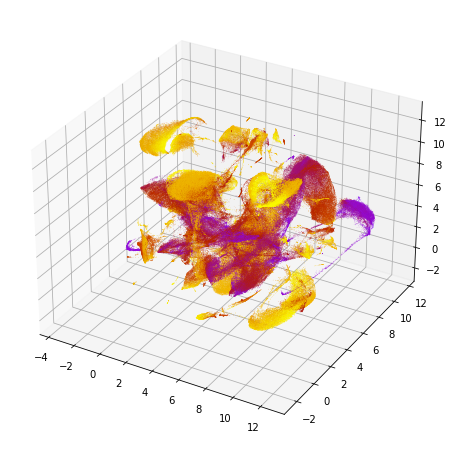

In [121]:
with loompy.connect('/proj/DEV_ATAC/Build_20220131/All/All.loom') as ds:    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    
    print(ds.ca.UMAP3D.shape)
    
    print(np.min(ds.ca.UMAP3D, axis=0))
    print(np.max(ds.ca.UMAP3D, axis=0))    
    
    x = np.where(ds.ca.Tissue=='Hindbrain')[0]
    
    ax.scatter(ds.ca.UMAP3D[:,0], ds.ca.UMAP3D[:,1], ds.ca.UMAP3D[:,2], marker = '.', lw=0, s=1, c=ds.ca.PseudoAge, cmap='gnuplot')

/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals_RAW/fragments_split/Adipocyte.bed
/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals_RAW/fragments_split/Cardiac_Fibroblasts.bed
/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals_RAW/fragments_split/Naive_T_cell.bed


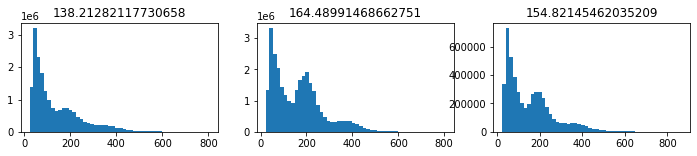

In [48]:
files = ['/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals_RAW/fragments_split/Adipocyte.bed',
        '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals_RAW/fragments_split/Cardiac_Fibroblasts.bed',
        '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals_RAW/fragments_split/Naive_T_cell.bed']
fig, ax = plt.subplots(1,3, figsize=(12,2))

for i, f in enumerate(files):
    print(f)
#     l = []
#     for x in X:
#         l.append(abs(int(x[1])-int(x[2])))
    sizes = [len(i) for i in BedTool(f)]
    ax[i].hist(sizes, bins=50)
    ax[i].set_title(np.mean(sizes))

(166988, 150)


16:37:42 INFO     Decomposition
16:37:43 INFO     Building graph
16:38:50 INFO     Clustering
17:06:36 INFO     Generating UMAP


UMAP(spread=2, verbose=True)
Construct fuzzy simplicial set
Thu Apr 14 17:06:36 2022 Finding Nearest Neighbors
Thu Apr 14 17:06:36 2022 Building RP forest with 25 trees
Thu Apr 14 17:06:41 2022 NN descent for 17 iterations
	 0  /  17
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
Thu Apr 14 17:07:04 2022 Finished Nearest Neighbor Search
Thu Apr 14 17:07:05 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Apr 14 17:10:51 2022 Finished embedding


17:10:52 INFO     Smoothing cluster identity on the UMAP embedding
17:12:37 INFO     Plotting Peak module UMAP


TypeError: sequence item 0: expected str instance, list found

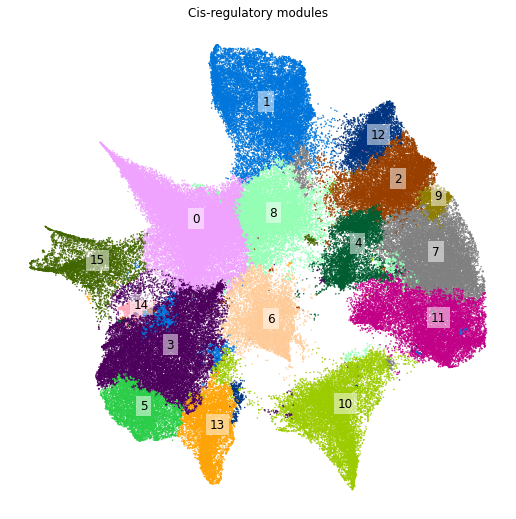

In [98]:
## TEMP
import numpy as np
import os
import sys
import loompy
import pickle as pkl

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
import matplotlib.pyplot as plt
import matplotlib
from sklearn.neighbors import NearestNeighbors

from cytograph.manifold import BalancedKNN
from cytograph.embedding import art_of_tsne
from cytograph.plotting.colors import colorize

from umap import UMAP

from sklearn.decomposition import PCA
from scipy import stats

import networkx as nx
import community
import igraph as ig
import logging
logger = logging.getLogger()

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

class peak_clustering:
    '''
    '''
    def init(self):
        self.config = config.load_config()
        
    def fit(self, ds: loompy.LoomConnection):
        X = ds['residuals'][:,:].astype(np.float32)
        
        if X.shape[1] > 50:
            logging.info(f'Decomposition')
            pca = PCA(n_components=40)
            X = pca.fit_transform(X)
        
        logging.info(f'Building graph')
        bnn = BalancedKNN(k=25, metric='euclidean', maxl= 50, sight_k=50, n_jobs=-1)
        bnn.fit(X)
        knn = bnn.kneighbors_graph(mode='distance')
        knn.eliminate_zeros()

        ## Cluster
        logging.info(f'Clustering')
        g = nx.from_scipy_sparse_matrix(knn)
        partitions = community.best_partition(g, resolution=1, randomize=False)
        labels = np.array([partitions[key] for key in range(knn.shape[0])])

        ## UMAP
        logging.info(f'Generating UMAP')
        ds.ra.UMAP = UMAP(n_components=2, metric='euclidean', verbose=True, spread=2).fit_transform(X)

        # Set the local cluster label to the local majority vote
        logging.info("Smoothing cluster identity on the UMAP embedding")
        nn = NearestNeighbors(n_neighbors=10, algorithm="ball_tree", n_jobs=4)
        nn.fit(ds.ra.UMAP)
        knn = nn.kneighbors_graph(mode='connectivity').tocoo()
        temp = []
        for ix in range(labels.shape[0]):
            neighbors = knn.col[np.where(knn.row == ix)[0]]
            temp.append(stats.mode(labels[neighbors])[0][0])
        ds.ra.Peak_cluster = np.array(temp)

        logging.info(f'Plotting Peak module UMAP')
        names, labels = np.unique(ds.ra.Peak_cluster, return_inverse=True)
        colors = colorize(names)

        fig, ax = plt.subplots(1,1, figsize=(9,9));
        pos = ds.ra.UMAP
        for lbl in np.unique(labels):
            txt = str(lbl)
            (x, y) = np.median(pos[np.where(labels == lbl)[0]], axis=0)
            ax.text(x, y, txt, fontsize=12, bbox=dict(facecolor='white', alpha=0.5, ec='none'))
        ax.scatter(pos[:,0], pos[:,1], s=1, marker='.', c=colors[labels], cmap='Spectral')
        ax.axis('off');
        plt.title(f'Cis-regulatory modules')
        f_out = os.path.join('/'.join(*ds.filename.split('/')[:-1]), 'exported', 'cCRE_modules.png')
        plt.savefig(f_out, bbox_inches='tight')
        
        
f = '/proj/DEV_ATAC/embryo_4w_20220311/Pool/Pool_peaks.agg.loom'

with loompy.connect(f) as dsout:
    print(dsout.shape)
    PC = peak_clustering()
    PC.fit(dsout)

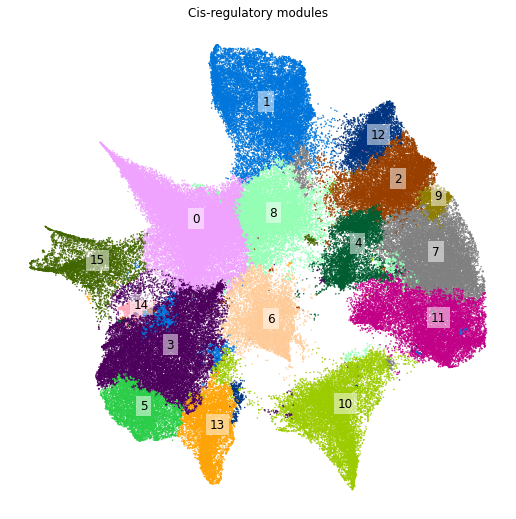

In [101]:
from cytograph.plotting.colors import colorize

with loompy.connect(f) as dsout:        
    names, labels = np.unique(dsout.ra.Peak_cluster, return_inverse=True)
    colors = colorize(names)
    
    fig, ax = plt.subplots(1,1, figsize=(9,9));
    pos = dsout.ra.UMAP
    
    for lbl in np.unique(labels):
        txt = str(lbl)
        (x, y) = np.median(pos[np.where(labels == lbl)[0]], axis=0)
        ax.text(x, y, txt, fontsize=12, bbox=dict(facecolor='white', alpha=0.5, ec='none'))

    ax.scatter(pos[:,0], pos[:,1], s=1, marker='.', c=colors[labels], cmap='Spectral')
    ax.axis('off');
    plt.title(f'Cis-regulatory modules');
    f_out = os.path.join('/'.join([*dsout.filename.split('/')[:-1]]), 'exported', 'cCRE_modules.png')

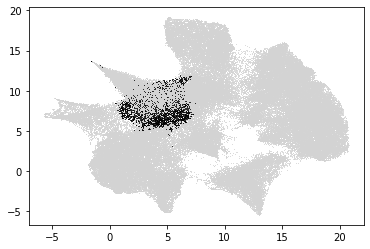

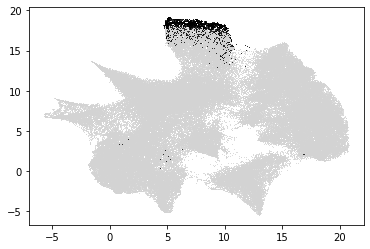

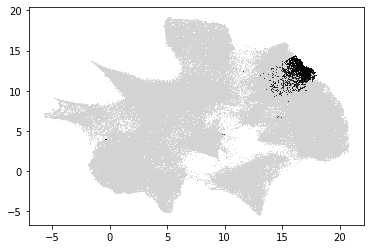

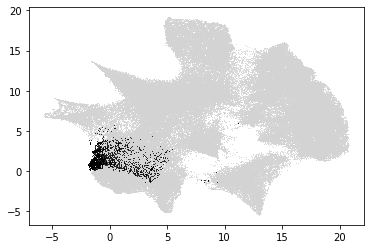

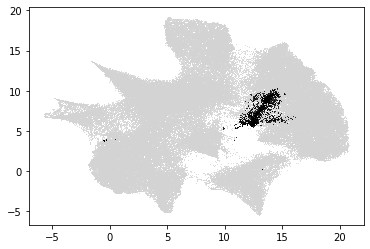

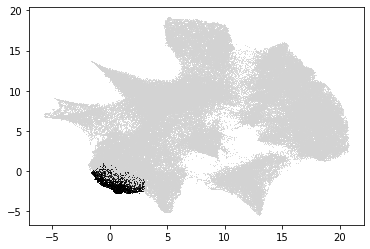

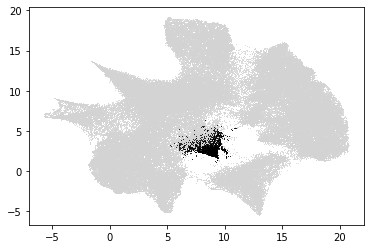

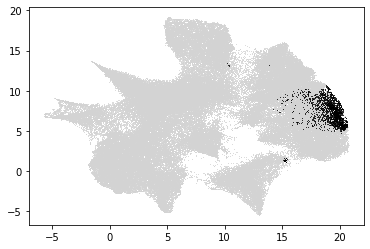

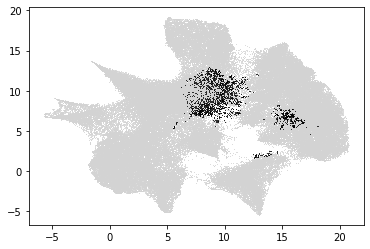

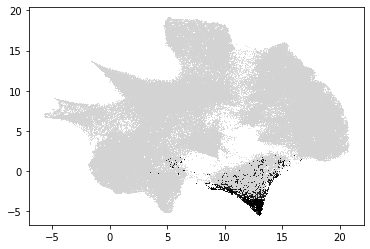

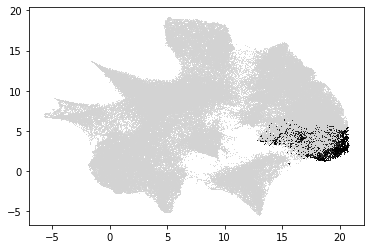

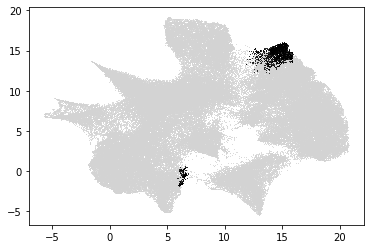

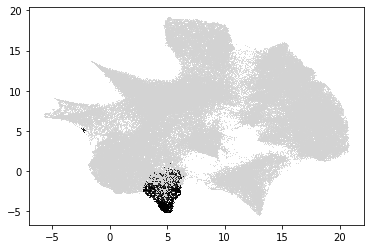

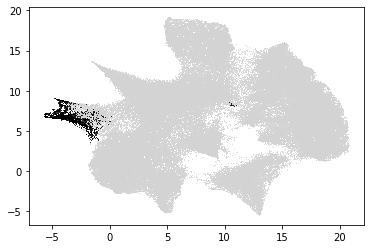

In [109]:
with loompy.connect(f) as ds:        

    for cls in np.unique(ds.ra.Peak_cluster):
        valid = np.where(ds.ra.Peak_cluster==cls)[0]
        if len(valid) > 2000:
            residuals = np.var(ds['residuals'][:,:][valid,:], axis=1)
            q = sorted(residuals)[-2000]
            valid = valid[residuals>=q]
            
#             plt.figure()
#             plt.scatter(ds.ra.UMAP[:,0], ds.ra.UMAP[:,1], lw=0, s=1, c='lightgray')
#             plt.scatter(ds.ra.UMAP[valid,0], ds.ra.UMAP[valid,1], lw=0, s=1, c='black')
        bd = BedTool([[ds.ra.Chr[x], ds.ra.Start[x], ds.ra.End[x]] for x in valid])
        bd.saveas(f'/proj/DEV_ATAC/test/{cls}_peaks.bed')

In [105]:
from collections import Counter

with loompy.connect(f) as ds:
    print(Counter(ds.ra.Peak_cluster))

Counter({0: 29314, 3: 19266, 1: 17133, 7: 14332, 11: 13099, 8: 12174, 10: 12033, 2: 10721, 6: 7429, 4: 6448, 13: 6161, 5: 6149, 15: 5434, 12: 4943, 9: 1639, 14: 713})


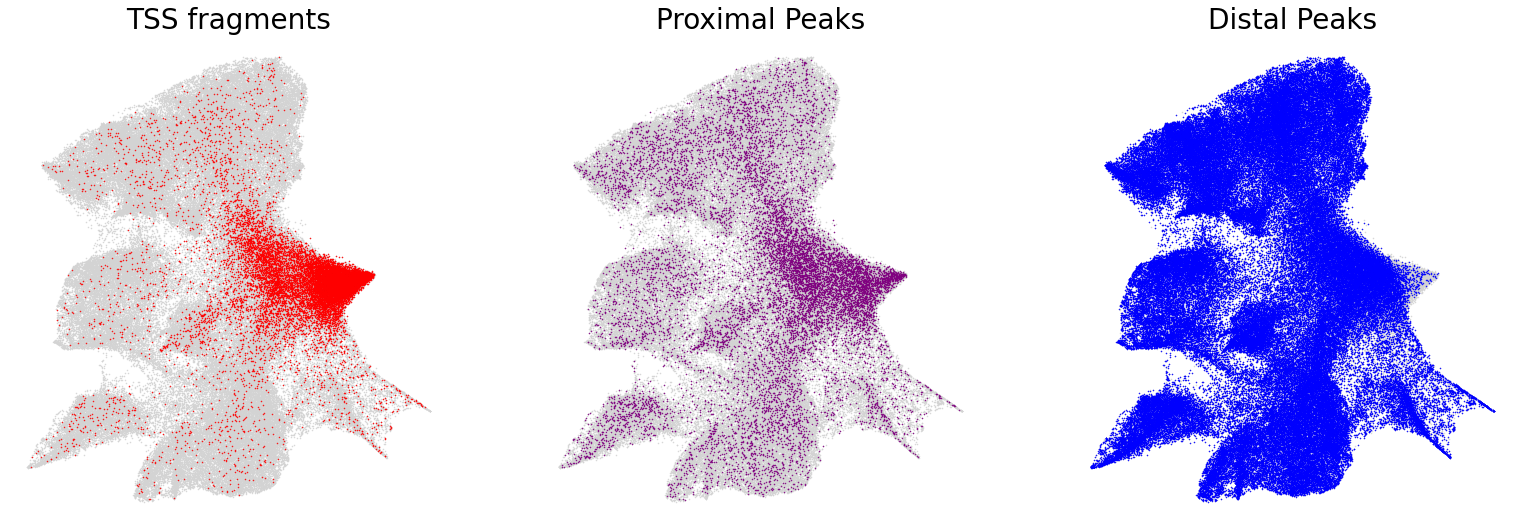

In [58]:
with loompy.connect(f) as dsout:    
    fig, ax = plt.subplots(1,3, figsize=(27,9));
    d = abs(dsout.ra['Distance to TSS'].astype(int))

    ax[0].set_title('TSS fragments', fontsize=28)
    ax[0].scatter(dsout.ra.UMAP[:,0], dsout.ra.UMAP[:,1], s=1, marker='.', c='lightgray')
    ax[0].scatter(dsout.ra.UMAP[d < 200,0], dsout.ra.UMAP[d<200,1], s=1, marker='.', c='red')
    ax[0].axis('off');

    ax[1].set_title('Proximal Peaks', fontsize=28)
    x = (d > 200) & (d < 2000)
    ax[1].scatter(dsout.ra.UMAP[:,0], dsout.ra.UMAP[:,1], s=1, marker='.', c='lightgray')
    ax[1].scatter(dsout.ra.UMAP[x,0], dsout.ra.UMAP[x,1], s=1, marker='.', c='purple')
    ax[1].axis('off');

    ax[2].set_title('Distal Peaks', fontsize=28)
    ax[2].scatter(dsout.ra.UMAP[:,0], dsout.ra.UMAP[:,1], s=1, marker='.', c='lightgray')
    ax[2].scatter(dsout.ra.UMAP[d > 2000,0], dsout.ra.UMAP[d>2000,1], s=1, marker='.', c='blue')
    ax[2].axis('off');

In [27]:
f = '/proj/DEV_ATAC/Build_20220131/All/All_peaks.loom'

with loompy.connect(f) as ds:
    x = ds.shape[1]
    l = np.where(ds.ca.Chemistry=='multiome_atac')[0].shape[0]
    
    print(f'{l} out of {x} cells, {(l/x)*100}%')

143533 out of 488935 cells, 29.35625389878%


In [23]:
import pyBigWig
from tqdm import tqdm

s = 'All'
width = 2500
resolution = 5
target_shapes = (250,250)
# target_shapes = None

# fdir = f'/proj/DEV_ATAC/GBM_20220204/{s}/'
fdir = f'/proj/DEV_ATAC/Build_20220131/{s}'
f = os.path.join(fdir, f'{s}_peaks.loom')
fagg =  os.path.join(fdir, f'{s}_peaks.agg.loom')
bigwigdir = os.path.join(fdir, f'bigwigs')

with loompy.connect(fagg) as dsagg:
    all_piles = []
    for cls in tqdm(range(dsagg.shape[1])):
        x = np.argsort(dsagg['residuals'][:,cls])[-1000:]
        chrs = dsagg.ra.Chr[x]
        positions = np.array(np.mean([dsagg.ra.End[x].astype(int), dsagg.ra.Start[x].astype(int)], axis=0)).astype(int)

        pile_ups = []
        for i in range(dsagg.shape[1]):
            with pyBigWig.open(os.path.join(bigwigdir, f'cluster_{i}.bw')) as bw:
                arr = np.zeros((len(positions), 2*width))
                for r, (chr, pos) in enumerate(zip(chrs, positions)):
                    arr[r,:] = np.nan_to_num(bw.values(chr, pos-width, pos+width, numpy=True),0)
                if target_shapes:
                    arr = rebin(arr, target_shapes)
                else:
                    arr = rebin(arr, [arr.shape[0],int(np.ceil(arr.shape[1]/resolution))])
                pile_ups.append(arr)
        all_piles.append(pile_ups)

  0%|          | 0/240 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
target_shapes = (500,500)

fig, ax = plt.subplots(len(all_piles),len(all_piles), figsize=(12,12))
for row, pile_ups in enumerate(all_piles):
    new_piles = [rebin(arr, target_shapes) for arr in pile_ups]
    q = np.max([np.quantile(arr,.99) for arr in new_piles])
    for  col, arr in enumerate(new_piles):
        x = np.argsort(arr.sum(1))[::-1]
        ax[row, col].imshow(arr[x,:], vmax=q, cmap='Blues')
        ax[row, col].axis('off')
        
plt.savefig('/home/camiel/misc/GBM_enriched_peaks.png')

## Old resutls

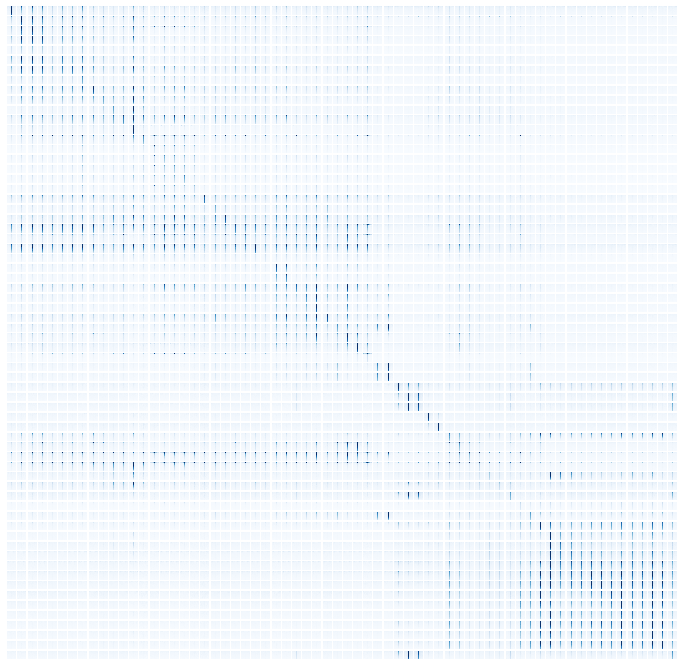

In [23]:
target_shapes = (500,500)

fig, ax = plt.subplots(len(all_piles),len(all_piles), figsize=(12,12))
for row, pile_ups in enumerate(all_piles):
    new_piles = [rebin(arr, target_shapes) for arr in pile_ups]
    q = np.max([np.quantile(arr,.99) for arr in new_piles])
    for  col, arr in enumerate(new_piles):
        x = np.argsort(arr.sum(1))[::-1]
        ax[row, col].imshow(arr[x,:], vmax=q, cmap='Blues')
        ax[row, col].axis('off')
        
plt.savefig('/home/camiel/misc/GBM_enriched_peaks.png')

In [ ]:
with loompy.connect(f) as ds:
    aneuploid = {}
    for c in np.unique(ds.ca.Clusters):
        vals,counts = np.unique(ds.ca.Aneuploid[np.where(ds.ca.Clusters==c)[0]], return_counts=True)
        aneuploid[c] = vals[np.argmax(counts)]        
    colors = {0: '#67a9cf', 1: '#ef8a62'}

fig, ax = plt.subplots(len(all_piles),len(all_piles), figsize=(12,12))
for row, pile_ups in enumerate(all_piles):
    q = np.max([np.quantile(arr,.99) for arr in pile_ups])
    for  col, arr in enumerate(pile_ups):
        x = np.argsort(arr.sum(1))[::-1]
        ax[row, col].imshow(arr[x,:], vmax=q, cmap='Blues')
        ax[row, col].axis('off')

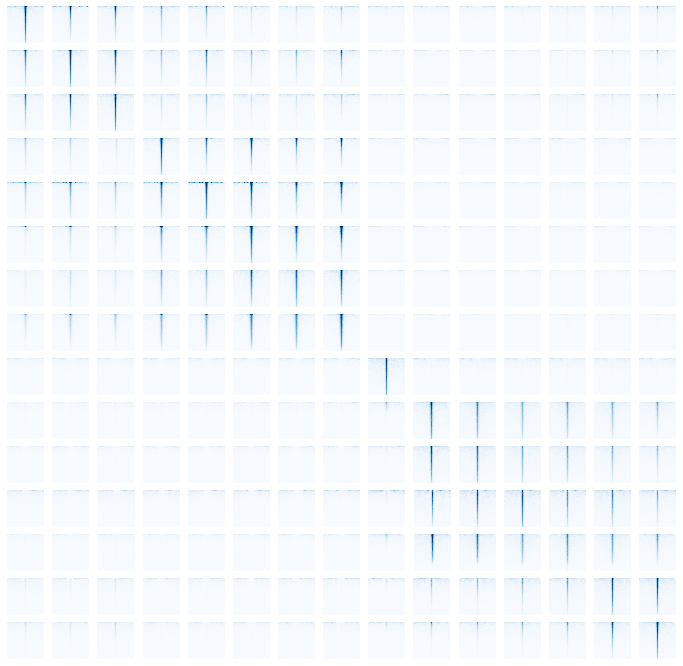

In [205]:
# fig, ax = plt.subplots(len(all_piles),len(all_piles), figsize=(12,12))

# for row, pile_ups in enumerate(all_piles):
#     q = np.max([np.quantile(arr,.99) for arr in pile_ups])
#     for  col, arr in enumerate(pile_ups):
#         x = np.argsort(arr.sum(1))[::-1]
#         ax[row, col].imshow(arr[x,:], vmax=q, cmap='Blues')
#         ax[row, col].axis('off')

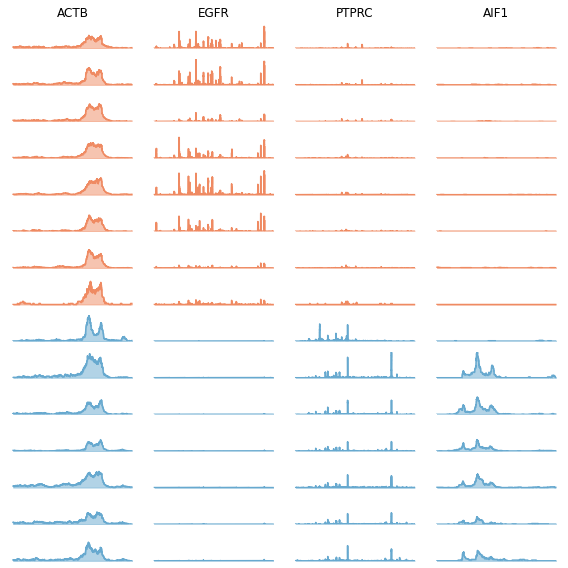

In [47]:
ranges = [
    ['ACTB', 'chr7', 5525148,5532601],
    ['EGFR', 'chr7', 54950864,55279647],
    ['PTPRC', 'chr1', 198569761,198826601],
    ['AIF1', 'chr6', 31613234,31619015]
]

s = 'SL011'
bigwig_dir = f'/proj/DEV_ATAC/GBM_20211116/{s}/bigwigs'
f = f'/proj/DEV_ATAC/GBM_20211116/{s}/{s}_peaks.loom'
fagg = f'/proj/DEV_ATAC/GBM_20211116/{s}/{s}_peaks.agg.loom'


with loompy.connect(f) as ds:
    aneuploid = {}
    for c in np.unique(ds.ca.Clusters):
        vals,counts = np.unique(ds.ca.Aneuploid[np.where(ds.ca.Clusters==c)[0]], return_counts=True)
        aneuploid[c] = vals[np.argmax(counts)]
        
colors = {0: '#67a9cf', 1: '#ef8a62'}

fig, ax = plt.subplots(len(aneuploid.keys()), len(ranges), figsize=(2*len(ranges), int(np.ceil(0.5*len(aneuploid.keys())))))
for c, ran in enumerate(ranges):
    data = []
    for i in range(len(aneuploid.keys())):
        with pyBigWig.open(f'{bigwig_dir}/cluster_{i}.bw') as bw:
            data.append(np.nan_to_num(bw.values(ran[1], ran[2], ran[3], numpy=True),0))

    x = np.fromiter(range(len(data[0])), dtype=int)
    height = max([max(x) for x in data])
    for i, v in enumerate(data):
        ax[i,c].plot(v, color=colors[aneuploid[i]])
        ax[i,c].fill_between(x,v, alpha=.5, color = colors[aneuploid[i]])
        ax[i,c].set_ylim(0,height)
        ax[i,c].axis('off')
    ax[0,c].set_title(ran[0])
plt.tight_layout()

In [ ]:
RNA_dir = '/proj/loom'
sample_dir = '/datb/sl/camiel/scATAC/samples/'

samples = glob.glob(os.path.join(sample_dir, f'10X*'))

for s in samples:
    print(s)
    sample = s.split('/')[-1]
    files = glob.glob(os.path.join(s, f'*.loom'))
    if len(files) > 0:
        for f in  files:
            with loompy.connect(f) as ds:
                if 'Chemistry' in ds.ca:
                    if ds.ca.Chemistry[0] == 'multiome_atac':
                        print(f'{f} mult')
                        with loompy.connect(os.path.join(RNA_dir, f'{sample}.loom')) as dsr:
                            RNA_bar = rna_barcodes_to_atac(dsr)
                            match = {k:v for v, k in enumerate(ds.ca.CellID)}

                            ## Initialize empty attributes
                            dbs, dbf = np.zeros((ds.shape[1],)).astype(np.float64), np.zeros((ds.shape[1],)).astype(np.int64)
                            TotalUMI, NGenes = np.zeros((ds.shape[1],)).astype(np.int64), np.zeros((ds.shape[1],)).astype(np.int64)
                            MT_ratio, unspliced_ratio = np.zeros((ds.shape[1],)).astype(np.float64), np.zeros((ds.shape[1],)).astype(np.float64)
                            tsne = np.zeros((ds.shape[1],2)).astype(np.float64)

                            for i, x in enumerate(RNA_bar):
                                k = match[x]
                                TotalUMI[k] = dsr.ca['TotalUMI'][i]
                                NGenes[k] = dsr.ca['NGenes'][i]
                                unspliced_ratio[k] = dsr.ca['unspliced_ratio'][i]
                                MT_ratio[k] = dsr.ca['MT_ratio'][i]

                            ds.ca['TotalUMI'] = TotalUMI
                            ds.ca['NGenes'] = NGenes
                            ds.ca['unspliced_ratio'] = unspliced_ratio
                            ds.ca['MT_ratio'] = MT_ratio

In [ ]:
## TEST RNA

In [19]:
samples = ['232_1', '232_2', '232_3', '232_4',
 '242_1', '242_2', '242_3', '242_4',
 '250_1', '250_2', '250_3', '250_4',
 '279_1', '279_2', '279_3',
 '280_1', '280_2', '280_3',
 '286_1', '286_2', '286_7', '286_8',
 '290_1', '290_2',
 '291_2', '291_3',
 '312_1', '312_2', '312_3', '312_4', '312_5', '312_6',
 '313_1', '313_2', '313_3', '313_4', '313_5', '313_6',
 '315_1', '315_2', '315_3', '315_4', '315_5', '315_6', '315_7', '315_8',
 '316_1', '316_3', '316_4', '316_5', '316_6',
 '317_1', '317_3', '317_4', '317_5', '317_6',
 '321_1', '321_2', '321_3', '321_4', '321_5', '321_6',
 '325_1', '325_2', '325_6',
 '340_1', '340_2', '340_3', '340_4',
 '346_1', '346_2', '346_3', '346_4',
 '347_1', '347_2', '347_3', '347_4',
 '364_2', '364_4',
 '365_2', '365_4',
 '366_1', '366_2', '366_4', '366_5', '366_6',
 '369_1', '369_2', '369_3', '369_4',
 '370_1', '370_2', '370_3', '370_4',
 '371_1', '371_2', '371_3',
 '372_1', '372_2', '372_3', '372_4',
 '402_1']
sample_dir = '/datb/sl/camiel/scATAC/samples/'

for s in samples:
    files = glob.glob(os.path.join(sample_dir, f'10X{s}', f'10X{s}*kb.loom'))
    for f in files:
        with loompy.connect(f) as ds:
            if 'SEX' not in ds.ca:
                print(f)
                SEX = 'F' if np.median(ds.ca.Y) < .0005 else 'M'
                ds.ca.SEX = np.repeat(SEX, ds.shape[1])

In [ ]:
samples = ['250_1', '250_2', '279_1', '280_1', '286_1', '286_2', '312_1', '312_2', '315_1', '315_2',
 '316_1', '317_1', '321_1', '321_2', '325_1', '325_2', '340_1', '346_1', '347_1', '364_2', '365_2']

sample_dir = '/datb/sl/camiel/scATAC/samples/'

for s in samples:
    files = glob.glob(os.path.join(sample_dir, f'10X{s}', f'10X{s}*kb.loom'))
    for f in files:
        with loompy.connect(f) as ds:()
            if 'SEX' not in ds.ca:
                print(f)
                SEX = 'F' if np.median(ds.ca.Y) < .0005 else 'M'
                ds.ca.SEX = np.repeat(SEX, ds.shape[1])

In [ ]:
from collections import Counter
with loompy.connect('/proj/DEV_ATAC/Skene_20220124/All/All.loom') as ds:
    print(Counter(ds.ca.Chemistry))

In [ ]:
import loompy
import numpy as np

samples = [['10X402_1', '9w'], ['10X346_2', '12w'], ['10X370_1', '13w']]
    
for sample in samples:
    s, o = [x for x in sample]
    file = f'/proj/loom/{s}.loom'
    output = f'/proj/DEV_ATAC/CTX_20220125/CTX_{o}/All_RNA.loom'
    with loompy.connect(file, 'r') as ds:
        good_cells = (ds.ca.DoubletFinderFlag == 0) & (ds.ca.TotalUMI > 1000) & (ds.ca.MT_ratio < 1) & (ds.ca.unspliced_ratio > 0.1)
        print(np.sum(good_cells), ds.shape[1])

    loompy.combine_faster([file], output, selections=[good_cells])

(36601, 16627)
['CellID', 'DoubletFinderFlag', 'DoubletFinderScore', 'MT_ratio', 'NGenes', 'PCA', 'TSNE', 'TotalUMI', 'unspliced_ratio']


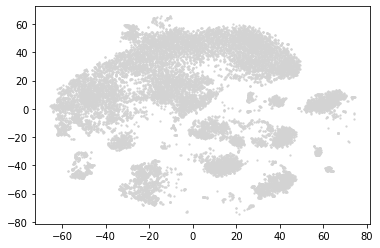

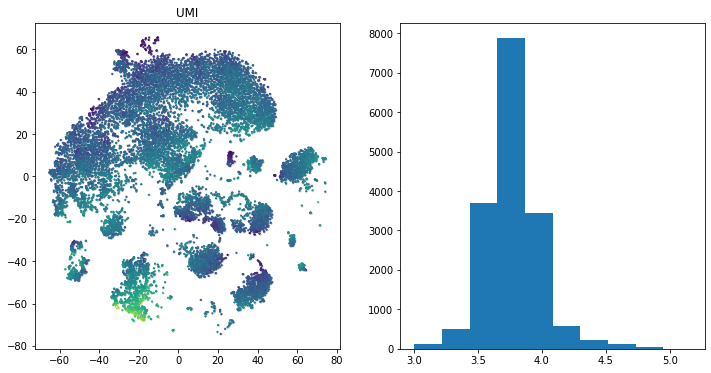

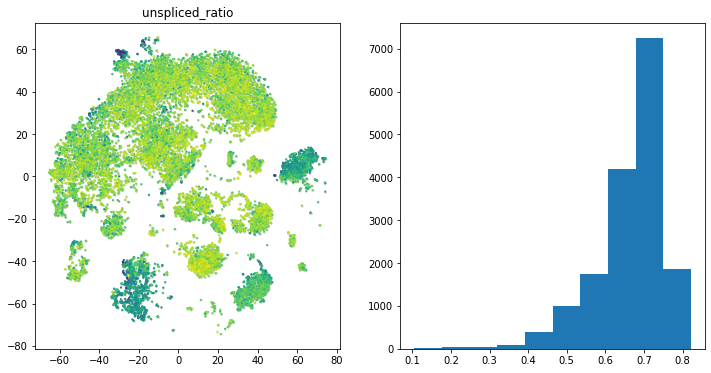

In [39]:
import matplotlib.pyplot as plt

with loompy.connect('/proj/DEV_ATAC/CTX_20220125/CTX_13w/All_RNA.loom', 'r') as ds:
    print(ds.shape)
    print(ds.ca.keys())
    
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], lw=0, s=5, c='lightgray')
    
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], lw=0, s=5, c='lightgray')
    ax[0].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], lw=0, s=5, c=np.log(ds.ca.TotalUMI), cmap='viridis')
    ax[0].set_title('UMI')
    ax[1].hist(np.log10(ds.ca.TotalUMI))
    
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], lw=0, s=5, c='lightgray')
    ax[0].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], lw=0, s=5, c=ds.ca['unspliced_ratio'], cmap='viridis')
    ax[0].set_title('unspliced_ratio')
    ax[1].hist(ds.ca['unspliced_ratio'])    

In [13]:
import numpy as np
import sys
import os
import subprocess
import loompy
import multiprocessing as mp
import pickle as pkl
import logging
import shutil
import pybedtools
from pybedtools import BedTool
import traceback
import chromograph
from scipy import sparse
import glob 

from chromograph.peak_calling.utils import *
import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

f = '/proj/DEV_ATAC/GBM_20211116/SL011/SL011_peaks.loom'
sample_dir = '/datb/sl/camiel/scATAC/samples/'
out_dir = '/'.join(f.split('/')[:-1]) + '/bigwigs'
logging.info(out_dir)
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

# cluster = 0
# with loompy.connect(f, 'r') as ds:
#     cells = [x.split(':') for x in ds.ca['CellID'][ds.ca['Clusters'] == cluster]]
#     export_bigwig(cells, sample_dir, out_dir, cluster, True)


with loompy.connect(f, 'r') as ds:
    with mp.get_context().Pool(min([len(np.unique(ds.ca.Clusters)), mp.cpu_count()])) as pool:
        for cluster in np.unique(ds.ca.Clusters):
            cells = [x.split(':') for x in ds.ca['CellID'][ds.ca['Clusters'] == cluster]]
            pool.apply_async(export_bigwig, args=(cells, sample_dir, out_dir, cluster,))
        pool.close()
        pool.join()
logging.info('finished all')

/proj/DEV_ATAC/GBM_20211116/SL011


(36601, 3731)
['Age', 'CellCycle', 'CellCycle_G1', 'CellCycle_G2M', 'CellCycle_S', 'CellCycle_phase', 'CellID', 'DoubletFinderFlag', 'DoubletFinderScore', 'IsCycling', 'MT_ratio', 'NGenes', 'PCA', 'TSNE', 'TotalUMI', 'unspliced_ratio']


Counter({'G1': 659, 'G0': 1290, 'G2': 513, 'S': 1269})

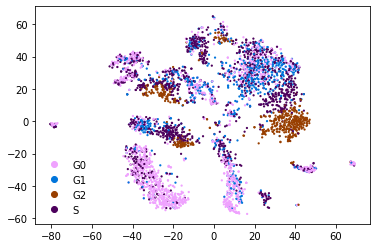

In [51]:
from cytograph.plotting.colors import colorize

attr = 'CellCycle_phase'
with loompy.connect('/proj/user/miri/integration/scanorama/pallium_ATAC/CTX_9w.loom', 'r') as ds:
    print(ds.shape)
    print(ds.ca.keys())
    
    names, labels = np.unique(ds.ca[attr], return_inverse=True)
    colors = colorize(names)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], lw=0, s=5, c=colors[labels], cmap='spectral')
        
    def h(c):
        return plt.Line2D([], [], color=c, ls="", marker="o")
    plt.legend(handles=[h(colors[i]) for i in range(len(names))], labels=list(names), loc='lower left', markerscale=1, frameon=False, fontsize=10)
    
from collections import Counter 
d = {i:k for i,k in enumerate(names)}
Counter([d[x] for x in labels])

In [65]:
from chromograph.RNA.utils import rna_barcodes_to_atac

main_dir = '/proj/DEV_ATAC/CTX_20220125'
for s in ['9w', '12w', '13w']:
    f = glob.glob(os.path.join(main_dir, s, '*_RNA.loom'))[0]
    
    with loompy.connect(f) as ds:
        names, labels = np.unique(ds.ca[attr], return_inverse=True)
        ds.ca.Clusters = labels
        
        if ds.ca.CellID[0][-1] == 'x':
            logging.info('RNA barcodes')
            RNA_bar = rna_barcodes_to_atac(ds)
            logging.info(ds.ca.CellID[:5])
            logging.info(RNA_bar[:5])
            
            ds.ca.RNAID = ds.ca.CellID
            ds.ca.CellID = RNA_bar
        
        if 'Name' not in ds.ca:
            ds.ca.Name = np.array([x.split(':')[0] for x in ds.ca.CellID])
            
        print(ds.ca.Name[:5])

['10X402_1' '10X402_1' '10X402_1' '10X402_1' '10X402_1']
['10X346_2' '10X346_2' '10X346_2' '10X346_2' '10X346_2']
['10X370_1' '10X370_1' '10X370_1' '10X370_1' '10X370_1']


(19901, 3731)
['', 'CPM', 'pooled', 'pooled_CPM']


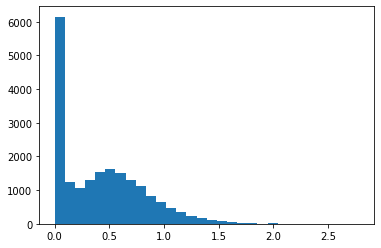

In [73]:
with loompy.connect('/proj/DEV_ATAC/CTX_20220125/9w/9w_prom.loom') as ds:
    print(ds.shape)
    print(ds.layers.keys())
    Totals = ds.map([np.mean], axis=0)[0]
    
    plt.hist(Totals, bins=30)

In [80]:
from cytograph.species import Species
from cytograph.plotting.heatmap import Heatmap

layer = ""
out_file = '/home/camiel/misc/test.png'

with loompy.connect('/proj/DEV_ATAC/CTX_20220125/9w/9w_prom.loom') as ds:
    with loompy.connect('/proj/DEV_ATAC/CTX_20220125/9w/9w_prom.agg.loom') as dsagg:    
        TFs = Species.detect(ds).genes.TFs
        enrichment = dsagg["enrichment"][:, :]
        enrichment = enrichment[np.isin(dsagg.ra.Gene, TFs), :]
        genes = dsagg.ra.Gene[np.isin(dsagg.ra.Gene, TFs)]
        genes = genes[np.argsort(-enrichment, axis=0)[:10, :]].T  # (n_clusters, n_genes)
        genes = np.unique(genes)  # 1d array of unique genes, sorted
        
        data = ds[np.where(np.isin(ds.ra.Gene, genes))[0],:]
        
#         hm = Heatmap(np.isin(ds.ra.Gene, genes), attrs={
#             "Clusters": "categorical",
#             "SampleName": "categorical",
#             "SampleID": "categorical",
#             "Tissue": "ticker",
#             "Sex": "categorical",
#             "Age": "categorical",
#             "TotalUMI": "plasma:log",
#             "CellCycle_G1": "viridis:log",
#             "CellCycle_S": "viridis:log",
#             "CellCycle_G2M": "viridis:log",
#             "DoubletFinderScore": "viridis",
#             "DoubletFinderFlag": "PiYG_r",
#         }, layer=layer)
#         hm.plot(ds, dsagg, out_file=out_file)

In [81]:
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [ ]:
import pybedtools
from pybedtools import BedTool
import os
import chromograph

for i in range(11):
    print(i)
    fmerge = f'cluster_{i}A.tsv.gz'
    f_unzip = f'{fmerge.split(".")[0]}.tsv'
    f_sort = f'{fmerge.split(".")[0]}_sorted.bed'
    os.system(f'gunzip {fmerge}')
    os.system(f'sort -k 1,1 -k2,2n {f_unzip} > {f_sort}')

    cov = 1e6 / BedTool(f_sort).count()
    f_bg = f'{f_sort.split(".")[0]}.bdg'
    f_genome = os.path.join(chromograph.__path__[0], 'references/male.GRCh38.chrom.sizes')
    os.system(f'bedtools genomecov -i {f_sort} -g {f_genome} -scale {cov} -bg > {f_bg}')

    ## Convert to bigwig
    outfile = f'{fmerge.split(".")[0]}.bw'
    pybedtools.contrib.bigwig.bedgraph_to_bigwig(BedTool(f_bg), genome='hg38', output=outfile)

In [ ]:
samples = np.loadtext('/datb/sl/camiel/scATAC/samples/')

In [ ]:
## Miscelaneous
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm
import pickle as pkl

import pandas as pd

import pybedtools
from pybedtools import BedTool

import subprocess

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
from chromograph.pipeline import config
from chromograph.preprocessing.doublet_finder import doublet_finder

import cytograph as cg
import cytograph.plotting as cgplot
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species 

import glob

import fisher

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as stats
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

config = config.load_config()

from chromograph.pipeline.TF_IDF import TF_IDF


In [ ]:
test = BedTool(os.path.join(fdir, 'cluster_0A_peaks.narrowPeak'))

centers, chr = [], []

for x in test:
    centers.append(np.floor(int(int(x[1]) + int(x[2]))/2).astype(int))
    chr.append(x[0])

peaks = BedTool([[c, str(x), str(x+1)] for c, x in zip(chr, centers)])

In [ ]:
files = glob.glob(os.path.join(fdir, f'cluster_0*.narrowPeak'))
bd = [BedTool(f) for f in files]
inter = bd[0].intersect(bd[1], wo=True)

In [ ]:
centers, chr = [], []

for x in inter:
    m1 = np.floor(int(int(x[1]) + int(x[2]))/2)
    m2 = np.floor(int(int(x[11]) + int(x[12]))/2)
    centers.append(np.floor((m1+m2)/2).astype(int))
peaks.append(BedTool([[c, str(x), str(x+1)] for c, x in zip(chr, centers)]))

In [ ]:
x = np.array([int(x[2]) - int(x[1]) for x in inter])
plt.hist(x);

In [ ]:
peaksize = 500
if peaksize%2 != 0:
    peaksize += 1
fdir = '/proj/DEV_ATAC/simple_test/All/peaks'
g_path = os.path.join(chromograph.__path__[0], 'references/male.GRCh38.chrom.sizes')
files = glob.glob(os.path.join(fdir, f'*summits.bed'))
peaks = []
count = []

for i in np.unique(range(11)):
    files = glob.glob(os.path.join(fdir, f'cluster_{i}*summits.bed'))
    bd = [BedTool(f).slop(b=int(peaksize/2), g=g_path) for f in files]
    inter = bd[0].intersect(bd[1], wo=True)

    centers, chr = [], []
    for x in inter:
        m1 = np.floor(int(int(x[1]) + int(x[2]))/2)
        m2 = np.floor(int(int(x[6]) + int(x[7]))/2)
        centers.append(np.floor((m1+m2)/2).astype(int))
        chr.append(x[0])
    peaks.append(BedTool([[c, str(x), str(x+1)] for c, x in zip(chr, centers)]))
    count.append(peaks[-1].count())

summits = peaks[0].cat(*peaks[1:])
clustered = summits.cluster(d=peaksize).saveas(os.path.join(fdir, 'clustered.bed'))
print(clustered.count(), f'per cluster {np.mean(count)}')

# summits = [BedTool(f) for f in files]
# summits = summits[0].cat(*summits[1:])
# summits.cluster(d=peaksize).saveas(os.path.join(fdir, 'clustered.bed'))

n_cls = len(np.unique([int(x[3]) for x in clustered]))
sums, n = np.zeros(n_cls), np.zeros(n_cls)
chr = {}
for x in clustered:
    id = int(x[3]) -1
    sums[id] += int(x[1])
    n[id] += 1
    if id not in chr:
        chr[id] = x[0]
        
centers = np.floor(sums/n).astype(int)
chr = [chr[i] for i in range(n_cls)]

peaks = BedTool([[c, str(x), str(x+1)] for c, x in zip(chr, centers)])
peaks = peaks.slop(b=int(peaksize/2), g=g_path)
peaks.saveas(os.path.join(fdir, 'tested_fixed.bed'))
print(f'Total peaks: {peaks.count()}')
print(f'Compounded peaks: {BedTool(os.path.join(fdir, "Compounded_peaks.bed")).count()}')

In [ ]:
key = 'CellID'

with loompy.connect('/proj/DEV_ATAC/Build_20211201_Ycor/All/All_peaks.loom') as ds1:
    with loompy.connect('/proj/DEV_ATAC/Build_20211201_Ycor/All/All.loom') as ds2:
    
        if np.array_equal(ds1.ca.CellID, ds2.ca.CellID):
            logging.info('Datasets already ordered')
        else:
            ## Align the datasets
            logging.info('Permuting dataset 2 based on order of dataset 1')
            match = {k:v for v, k in enumerate(ds1.ca[key])}
            new_index = np.array([match[x] for x in ds2.ca[key]]).argsort()
            ds2.permute(new_index, axis=1)
            logging.info(f'Finished permuting datasets')

        ## Transfer column attributes
        for x in ds1.ca:    ## Don't check if attribute already present as it will prevent transfer of TSNE coordinates
            ds2.ca[x] = ds1.ca[x]

        ## Transfer column graphs
        for x in ds1.col_graphs:
            ds2.col_graphs[x] = ds1.col_graphs[x]


In [ ]:
x = [int(x[2]) - int(x[1]) for x in peaks]
plt.hist(x)

In [ ]:
from chromograph.plotting.QC_plot import QC_plot
 
name = 'All'
plot_attrs = ['SEX', 'Shortname', 'Chemistry', 'Tissue']
outdir = '/proj/DEV_ATAC/Build_20211201_Ycor/All/exported'

with loompy.connect(os.path.join(outdir, 'All_peaks.loom')) as ds:
    QC_plot(ds, os.path.join(outdir, f"{name}_peaks_TSNE_QC.png"), embedding = 'TSNE', attrs=plot_attrs)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30,10))

with loompy.connect('/proj/DEV_ATAC/Build_20211201_Ycor/All/All_copy.loom') as ds:
    im = ax[0].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds.ca.Y, cmap = 'viridis', vmax=0.001, marker='.', lw=0,  s=1)
    ax[0].axis('off')
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    ax[0].set_title(f'Y chromosomal reads')
    
    names, labels = np.unique(ds.ca.SEX, return_inverse=True)
    colors = colorize(names)
    ax[1].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=colors[labels], marker='.', lw=0,  s=1)
    ax[1].axis('off')
    
    def h(c):
        return plt.Line2D([], [], color=c, ls="", marker="o")
    ax[1].legend(handles=[h(colors[i]) for i in range(len(names))], labels=list(names), loc='lower right', markerscale=1, frameon=False, fontsize=10)
    ax[1].set_title(f'Sex of embryo')
    ax[1].axis("off")
    
    im = ax[2].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds.ca.Age, cmap = 'viridis', marker='.', lw=0,  s=1)
    ax[2].axis('off')
    fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=.5)
    ax[2].set_title(f'Age')
    
    print(Counter(ds.ra.chrom[np.where(ds.ra.Valid)[0]]))

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
emb = 'TSNE_bin'

with loompy.connect('/proj/DEV_ATAC/Build_20211016/All/All.loom') as ds:
    print(ds.ca.keys())
    Y = np.sum(ds[np.where(ds.ra.chrom == 'chrY')[0],:], axis=0) / ds.ca.passed_filters
    im = ax[0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c=Y, cmap = 'viridis', vmax=0.001, marker='.', lw=0,  s=1)
    ax[0].axis('off')
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    ax[0].set_title(f'Y chromosomal reads')
        
    im = ax[1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c=ds.ca.Age, cmap = 'viridis', marker='.', lw=0,  s=1)
    ax[1].axis('off')
    fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)
    ax[1].set_title(f'Age')
    
    print(Counter(ds.ra.chrom[np.where(ds.ra.Valid)[0]]))

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

with loompy.connect('/proj/DEV_ATAC/Build_20211016/All/All.loom') as ds:
    print(ds.ca.keys())
    Y = np.sum(ds[np.where(ds.ra.chrom == 'chrY')[0],:], axis=0) / ds.ca.passed_filters
    im = ax[0].scatter(ds.ca['TSNE'][:,0], ds.ca['TSNE'][:,1], c=Y, cmap = 'viridis', vmax=0.001, marker='.', lw=0,  s=1)
    ax[0].axis('off')
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    ax[0].set_title(f'Y chromosomal reads')
        
    im = ax[1].scatter(ds.ca['TSNE_bin'][:,0], ds.ca['TSNE_bin'][:,1], c=Y, cmap = 'viridis', vmax=0.001, marker='.', lw=0,  s=1)
    ax[1].axis('off')
    fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)
    ax[1].set_title(f'Y chromosomal reads bin')
    
    print(Counter(ds.ra.chrom[np.where(ds.ra.Valid)[0]]))

In [ ]:
g = 'PCP4'
with loompy.connect('/proj/DEV_ATAC/Build_20211016/All/All_RNA_imputed.loom') as ds:
    with loompy.connect('/proj/DEV_ATAC/Build_20211016/All/All_RNA.loom') as dsr:
        X = ds['pooled'][ds.ra.Gene==g,:].flatten()
        plt.hist(X[X>0], bins=20, range=(0,20))
        print(np.sum(X>0)/X.shape[0])
        print(X[X>0][:10])
        
        plt.figure()
        X = dsr[dsr.ra.Gene==g,:].flatten()
        plt.hist(X[X>0], bins=20, range=(0,20))
        print(np.sum(X>0)/X.shape[0])
        print(X[X>0][:10])

In [ ]:
## Imports
import os
import sys
import collections
import loompy
from tqdm import tqdm
from typing import *
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

from collections import Counter
from pynndescent import NNDescent

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.pipeline import config
from chromograph.RNA.utils import *
from chromograph.plotting.sample_distribution_plot import sample_distribution_plot

import cytograph as cg
import cytograph.plotting as cgplot
from cytograph.species import Species
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import Trinarizer

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

layer = 'pooled'
autoannotation = "/home/camiel/auto-annotation/Human"
RNA_file = '/proj/DEV_ATAC/Build_20211016/All/All_RNA_imputed.loom'
RNA_agg = '/proj/DEV_ATAC/Build_20211016/All/All_RNA_imputed.agg.loom'
agg_spec = {
"Age": "mean",
"Clusters": "first",
"Class": "mode",
"Total": "mean",
"Sex": "tally",
"Tissue": "tally",
"Chemistry": "tally",
"SampleID": "tally",
"TissuePool": "first",
"Outliers": "mean",
"PCW": "mean"
}

with loompy.connect(RNA_file) as ds:
    cells = ds.col_attrs["Clusters"] >= 0
    labels = ds.col_attrs["Clusters"][cells]
    n_labels = len(set(labels))

    logging.info(f'Aggregating file using layer {layer}')
#     ds.aggregate(RNA_agg, None, "Clusters", "mean", agg_spec, layer=layer)

    with loompy.connect(RNA_agg) as dsout:
        dsout.ca.NCells = np.bincount(labels, minlength=n_labels)[dsout.ca.Clusters]

        logging.info("Computing cluster gene enrichment scores")
        fe = FeatureSelectionByMultilevelEnrichment(mask=Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt")))
        markers = fe.fit(ds)
        dsout.layers["enrichment"] = fe.enrichment

        # Reorder the genes, markers first, ordered by enrichment in clusters
        logging.info("Permuting rows")
        mask = np.zeros(ds.shape[0], dtype=bool)
        mask[markers] = True
        # fetch enrichment from the aggregated file, so we get it already permuted on the column axis
        gene_order = np.zeros(ds.shape[0], dtype='int')
        gene_order[mask] = np.argmax(dsout.layer["enrichment"][mask, :], axis=1)
        gene_order[~mask] = np.argmax(dsout.layer["enrichment"][~mask, :], axis=1) + dsout.shape[1]
        gene_order = np.argsort(gene_order)
        ds.permute(gene_order, axis=0)
        dsout.permute(gene_order, axis=0)

        logging.info(f'Trinarizing')
        trinaries = Trinarizer(0.2).fit(ds)
        dsout['trinaries'] = trinaries[:,dsout.ca.Clusters]

        logging.info(f'Annotating')
        AutoAnnotator(autoannotation, ds=dsout).annotate(dsout)

        logging.info("Computing auto-auto-annotation")
        AutoAutoAnnotator(n_genes=6).annotate(dsout)


In [ ]:
with loompy.connect(RNA_agg) as ds:
    X = ds.map([np.sum], axis=1)[0]
    plt.hist(X, range=(0,10000), alpha=.5)
    
with loompy.connect('/proj/DEV_ATAC/Build_20211016/All/All_RNA.agg.loom') as ds:
    X = ds.map([np.sum], axis=1)[0]
    plt.hist(X, range=(0,10000), alpha=.5)

In [ ]:
with loompy.connect(RNA_file) as ds:
    X = ds['pooled'].map([np.sum], axis=1)[0]
    plt.hist(X, range=(0,10000), alpha=.5)
with loompy.connect('/proj/DEV_ATAC/Build_20211016/All/All_RNA.loom') as ds:
    X = ds[''].map([np.sum], axis=1)[0]
    plt.hist(X, range=(0,10000), alpha=.5)

In [ ]:
np.min(X)

In [ ]:
with loompy.connect('/proj/DEV_ATAC/Build_20211016/All/All_peaks.agg.loom') as ds:
    XY = np.isin(ds.ra.Chr, ['chrX', 'chrY'])
    print(np.sum(XY))

In [ ]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import loompy
from chromograph.motifs.motif_aggregation import motif_aggregator
import warnings

import chromograph
from chromograph.pipeline import config
from chromograph.pipeline.utils import div0
from chromograph.peak_calling.utils import *
from chromograph.peak_analysis.utils import *
from chromograph.plotting.motif_heatmap import Motif_heatmap
import pandas as pd

import cytograph as cg
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

name = 'All'
MA = motif_aggregator(name)
MA.fit()

In [ ]:
Full_names = {'Fol': 'Follicular Cell of Thyroid',
              'Acn': 'Acinal Cell of Pancreas', 
              'Skm1': 'Skeletal Myocyte 1',
              'Fib.1': 'Fibroblast 1', 
              'Mac.1':'Macrophage 1', 
              'Vsm.1': 'Vascular Smooth Muscle 1',
              'Fib.2': 'Fibroblast 2',
              'End.1': 'Endothelial 1',
              'Esm.1': 'Esophagal Smooth Muscle 1',
              'Enc.1': 'Enterocyte (Large Intestine) 1',
              'Vsm.2': 'Vascular Smooth Muscle 2',
              'Skm2': 'Skeletal Myocyte 2',
              'Smm.1': 'Smooth Muscle (general)',
              'Msc': 'Miscellaneous stromal cell',
              'Mac.2': 'Macrophage 2',
              'Tly.1': 'T lymphocyte 1',
              'Fib.3': 'Fibroblast 3',
              'End.2': 'Endothelial 2',
              'Mfb.1': 'Myofibroblast 1',
              'Cam': 'Cardiomyocyte',
              'Swn.1': 'Schwann 1',
              'Eep.1': 'Esophageal Epithelial 1',
              'Tly.2': 'T Lymphocyte 2',
              'Pal': 'Pneumocyte',
              'Fib.4': 'Fibroblast 4',
              'Enc.2': 'Enterocyte 2',
              'Adc': 'Acortical Cell of Adrenal Gland',
              'Eep.2': 'Esophageal Epithelial 2',
              'Epc': 'Epithelial (general)',
              'Grn': 'Granulosa',
              'Gcf': 'Gastric Chief',
              'Bas.1': 'Basal 1',
              'Bly': 'B Lymphocyte',
              'Krt': 'Keratinocyte',
              'Prt': 'Gastric Parietal',
              'Hpc': 'Hepatocyte',
              'Lue': 'Luminal Epithelial',
              'Fib.5': 'Fibroblast 5',
              'Mfb.2': 'Myofibrobals 2',
              'Gbl.1': 'Goblet Cell 1 (Small Intestine)',
              'Gbl.2': 'Goblet Cell 2 (Small Intestine)',
              'Dut': 'Dutal',
              'Mes': 'Mesothelial',
              'Mst': 'Mast',
              'Adi': 'Adipocyte',
              'Nec': 'Neuroendocrine',
              'Enc.3': 'Enterocyte 3',
              'Esm.2': 'Esophagal Smooth Muscle 2',
              'Agb': 'Airway Goblet',
              'Fib.6': 'Fibrobalst 6',
              'Stl': 'Myosatellite',
              'Bas.2': 'Basal 2',
              'Mac.3': 'Macrophage 3',
              'Swn.2': 'Schwann 2'}

with loompy.connect('/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/ALL_cCRE.agg.loom') as ds:
    ds.ca.Full_name = np.array([Full_names[x] for x in ds.ca.Cell_Type])

In [ ]:
with loompy.connect('/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/ALL_cCRE.agg.loom') as ds:
#     plt.hist(np.log10(ds[:,0].flatten()+1))
    ds.ca.NCells = np.repeat(1000, ds.shape[1])
    plt.hist(ds[:,0].flatten(), range(0,5))
    print(np.sum(ds[:,0].flatten()>1))

In [ ]:
with loompy.connect('/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/ALL_cCRE.agg.loom') as ds:
    print(ds.ra.keys())
    print(ds.ra.Chr.shape)
    
    print(ds.ra.Chr)
    
    print(ds.ra.Chr[0].split("'")[1])
    print(ds.ra.Start[0].split("'")[1])
    print(ds.ra.End[0].split("'")[1])
    
    ds.ra.Chr = np.array([x.split("'")[1] for x in ds.ra.Chr])
    ds.ra.Start = np.array([x.split("'")[1] for x in ds.ra.Start])
    ds.ra.End = np.array([x.split("'")[1] for x in ds.ra.End])

In [ ]:
#Imports
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import loompy
from typing import *
import multiprocessing as mp
import pybedtools
from pybedtools import BedTool
import multiprocessing as mp

from chromograph.pipeline import config
from chromograph.peak_analysis.utils import *

from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.manifold import GraphSkeletonizer
import cytograph.plotting as cgplot
from cytograph.plotting import manifold

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

with loompy.connect('/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/ALL_cCRE.agg.loom') as dsout:

    config = config.load_config()
    n_labels = dsout.shape[1]
    logging.info('Calculate coverage metrics')
    dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
    dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

    ## Normalize peak counts by total fragments per cluster
    logging.info('Convert to CPMs')
    dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

    ## Call positive and negative peaks for every cluster
    dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout, bounds=(5,40))

    ## Select markers by residuals
    markers = Enrichment_by_residuals(dsout)

    # Renumber the clusters
    logging.info("Renumbering clusters by similarity, and permuting columns")

    data = dsout[:, :][markers, :].T
    data[np.where(data<0)] = 0  ## BUG handling. Sometimes values surpass the bit limit in malignant cells
    data = np.log(data + 1)
    D = pdist(data, 'correlation')
    Z = hc.linkage(D, 'ward', optimal_ordering=True)
    ordering = hc.leaves_list(Z)

    # Permute the aggregated file, and renumber
    dsout.permute(ordering, axis=1)
    dsout.ca.Clusters = np.arange(n_labels)

    # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
    data = dsout[:, :][markers, :].T
    data[np.where(data<0)] = 0  ## BUG handling. Sometimes values surpass the bit limit in malignant cells
    data = np.log(data + 1)
    D = pdist(data, 'correlation')
    dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)

    ## Run Homer findMotifs to find the top 5 motifs per cluster
    logging.info(f'Finding enriched motifs among marker peaks')

    motifdir = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/motifs'
    if not os.path.isdir('/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/motifs'):
        os.mkdir(motifdir) 

    piles = []
    for x in range(dsout.shape[1]):
        Valids = dsout.layers['marker_peaks'][:,x]
        bed_file = os.path.join(motifdir, f'Cluster_{x}.bed')
        peaks = BedTool([(dsout.ra['Chr'][x], str(dsout.ra['Start'][x]), str(dsout.ra['End'][x]), str(dsout.ra['ID'][x]), '.', '+') for x in np.where(Valids)[0]]).saveas(bed_file)
        piles.append([bed_file, os.path.join(motifdir, f'Cluster_{x}')])

    for pile in piles:
        Homer_find_motifs(bed=pile[0], outdir=pile[1], homer_path=config.paths.HOMER, motifs=os.path.join(chromograph.__path__[0], 'references/human_TFs.motifs'), cpus=mp.cpu_count())

    dsout.ca.Enriched_Motifs = retrieve_enrichments(dsout, motifdir, N=config.params.N_most_enriched)

In [ ]:
GBM = BedTool('/datb/sl/camiel/tumor/outputs/enhancers_20210323.bed')
peaks = BedTool('/proj/DEV_ATAC/Build_20211016/All/peaks/Compounded_peaks.bed')

overlap = peaks.intersect(GBM, wb=True)

IDs = [x[3] for x in overlap]

In [ ]:
f_peaks = '/proj/DEV_ATAC/Build_20211016/All/All_peaks.loom'
with loompy.connect(f_peaks, 'r') as ds:
    print(ds.ra.keys())
    print(ds.ra['Distance to TSS'])

In [ ]:
f_peaks = '/proj/DEV_ATAC/Build_20211016/All/All_peaks.loom'
with loompy.connect(f_peaks, 'r') as ds:
    print(ds.layers.keys())
    valids = np.where(np.isin(ds.ra.ID, IDs))[0]

    nrows = int(np.ceil(len(valids)/8))
    fig, ax = plt.subplots(nrows,8, figsize=(32,(nrows*4)))
    ax = ax.flatten()
    
    for i, pos in enumerate(valids):
        v = ds[pos,:]
        x = v > 0
        ax[i].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c='lightgray', s=1, marker=',')
        ax[i].scatter(ds.ca.TSNE[x,0], ds.ca.TSNE[x,1], c='red', s=1, marker=',')
        ax[i].set_title(ds.ra.ID[pos], fontsize=8)
        
    for i in range(len(ax)):
        ax[i].axis('off')

In [ ]:
fagg = '/proj/DEV_ATAC/Build_20211016/All/All_peaks.agg.loom'

with loompy.connect(fagg, 'r') as ds:
    print(ds.layers.keys())
    for x in valids:
        plt.figure()
        plt.hist(ds['residuals'][x,:], range=(0,10))

In [ ]:
from matplotlib.collections import LineCollection

lines = np.array([9, 20, 24, 44, 56, 61, 73, 77, 87, 106, 130, 
         134, 147, 161, 166, 175, 190, 193, 197, 200])

xlabels = ['M. Inh.', 'Pept.', 'RN',  'CB Inh.', 'Purk.', 'Cort. Glut.', 'Cort. Rgl', 
           'FP', 'Opc', 'M/H Rgl',  'H Npc',  'CB Rgl', 'M Rgl', 'H Glut.', 'H Pept.', 
           'Gran.', 'Mgl',  'Ery', 'Endo', 'Pery']

strip_height = 1
offset = 0

xticks = [lines[0]/2]
for i in range(1,len(lines)):
    xticks.append((lines[i]+lines[i-1]+1)/2)
    
with loompy.connect(fagg, 'r') as ds:
    X = ds['log2fc'][valids,:].astype(np.float32)
    size = X.shape[0]

    total_height = size + 2*strip_height
    grid = (total_height, 1)

    plt.figure(figsize=(X.shape[1],total_height))

    d = ds.ca.Age
    ax = plt.subplot2grid(grid, (offset, 0), rowspan=strip_height)
    offset += strip_height
    plt.imshow(np.expand_dims(d, axis=0), aspect='auto', cmap='gnuplot', interpolation='nearest')
    plt.text(0, 0.9, 'Age', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=7, color="black")
    plt.axis("off")
    
    for i in range(X.shape[0]):
        ax = plt.subplot2grid(grid, (offset, 0), rowspan=strip_height)
        ax.imshow(np.expand_dims(X[i,:],axis=0), aspect='auto', cmap='coolwarm', vmin = -5, vmax = 5, interpolation='nearest')
        offset += strip_height
        plt.axis("off")
    fig.suptitle('Log2fc', fontsize=128)
    
    ax = plt.subplot2grid(grid, (offset, 0), rowspan=X.shape[0])
    
    tops = np.vstack((lines - 0.5, np.zeros(lines.shape[0]) - 0.5)).T
    bottoms = np.vstack((lines - 0.5, np.zeros(lines.shape[0]) + X.shape[0] - 0.5)).T
    lc = LineCollection(zip(tops, bottoms), linewidths=1, color='black', alpha=0.5)
    ax.add_collection(lc)
    plt.axis("off")
    
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(xlabels, fontsize=128)
    
#     plt.figure()
#     X = ds['CPM'][valids,:].astype(np.float32)
#     plt.imshow(X, cmap='viridis', vmin = 0, vmax = 30)
#     plt.title('CPM')       


In [ ]:
from matplotlib.collections import LineCollection

fagg = '/proj/DEV_ATAC/Build_20211016/All/All_peaks.agg.loom'

lines = np.array([9, 20, 24, 44, 56, 61, 73, 77, 87, 106, 130, 
         134, 147, 161, 166, 175, 190, 193, 197, 200])

xlabels = ['M. Inh.', 'Pept.', 'RN',  'CB Inh.', 'Purk.', 'Cort. Glut.', 'Cort. Rgl', 
           'FP', 'Opc', 'M/H Rgl',  'H Npc',  'CB Rgl', 'M Rgl', 'H Glut.', 'H Pept.', 
           'Gran.', 'Mgl',  'Ery', 'Endo', 'Pery']

strip_height = 1
offset = 0

xticks = [lines[0]/2]
for i in range(1,len(lines)):
    xticks.append((lines[i]+lines[i-1]+1)/2)
    
with loompy.connect(fagg, 'r') as ds:
    X = ds['log2fc'][valids,:].astype(np.float32)
    size = X.shape[0]

    total_height = size + 2*strip_height
    grid = (total_height, 1)

    plt.figure(figsize=(X.shape[1],total_height))

    d = ds.ca.Age
    ax = plt.subplot2grid(grid, (offset, 0), rowspan=strip_height)
    offset += strip_height
    plt.imshow(np.expand_dims(d, axis=0), aspect='auto', cmap='gnuplot', interpolation='nearest')
    plt.text(0, 0.9, 'Age', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=7, color="black")
    plt.axis("off")
    
    for i in range(X.shape[0]):
        ax = plt.subplot2grid(grid, (offset, 0), rowspan=strip_height)
        ax.imshow(np.expand_dims(X[i,:],axis=0), aspect='auto', cmap='viridis', interpolation='nearest')
        offset += strip_height
        plt.axis('off')
    fig.suptitle('CPM', fontsize=128)
    
#     ax = plt.subplot2grid(grid, (offset, 0), rowspan=X.shape[0])
    
#     tops = np.vstack((lines - 0.5, np.zeros(lines.shape[0]) - 0.5)).T
#     bottoms = np.vstack((lines - 0.5, np.zeros(lines.shape[0]) + X.shape[0] - 0.5)).T
#     lc = LineCollection(zip(tops, bottoms), linewidths=1, color='black', alpha=0.5)
#     ax.add_collection(lc)
#     plt.axis("off")
    
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(xlabels, fontsize=128)


In [ ]:
fig, ax = plt.subplots()
ax.imshow(np.zeros((110,200)))
lc = LineCollection(zip(tops, bottoms), linewidths=1, color='black', alpha=0.5)
ax.add_collection(lc)

In [ ]:
X.mean(1).shape

In [ ]:
with loompy.connect(fagg, 'r') as ds:
    print(ds.layers.keys())
    valids = np.where(np.isin(ds.ra.ID, IDs))[0]
    npos = []
    for x in valids:
        npos.append(ds['binary'][x,:].sum())
        
    npos = np.array(npos)
    plt.hist(npos)

In [ ]:
f_peaks = '/proj/DEV_ATAC/Build_20211016/All/All_peaks.loom'
with loompy.connect(f_peaks, 'r') as ds:
    print(ds.layers.keys())
    markers = valids[(npos>0)&(npos<50)]

    nrows = int(np.ceil(len(markers)/8))
    fig, ax = plt.subplots(nrows,8, figsize=(32,(nrows*4)))
    ax = ax.flatten()
    
    for i, pos in enumerate(markers):
        v = ds[pos,:]
        x = v > 0
        ax[i].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c='lightgray', s=1, marker=',')
        ax[i].scatter(ds.ca.TSNE[x,0], ds.ca.TSNE[x,1], c='red', s=1, marker=',')
        ax[i].set_title(ds.ra.ID[pos], fontsize=8)
        
    for i in range(len(ax)):
        ax[i].axis('off')

In [ ]:
fd = '/datb/sl/camiel/scATAC/samples/'

samples = os.listdir(fd)
nrows = int(np.ceil(len(samples)/6))

fig, ax = plt.subplots(nrows, 6, figsize=(24, 4*nrows))
ax = ax.flatten()

for i, s in enumerate(samples):
    sdir  = os.path.join(fd, s)
    if len(glob.glob(sdir + '/*5kb.loom')) > 0:
        f5 = glob.glob(sdir + '/*5kb.loom')[0]
        files = glob.glob(sdir + '/*kb.loom')

        if os.path.isfile(f5):
            with loompy.connect(f5) as ds:
                Y = np.sum(ds[np.where(ds.ra.chrom == 'chrY')[0],:], axis=0) / ds.ca.passed_filters
                ds.ca.Y = Y
                ax[i].hist(ds.ca.Y, bins=30, range=(0,.005))
                ax[i].set_title(s)

            for f in files:
                if f != f5:
                    with loompy.connect(f) as ds:
                        ds.ca.Y = Y


In [ ]:
# fdir = '/data/proj/AllenInst/ATAC_builds/ATAC_clustering/'

# for d in os.listdir(fdir):
#     files = glob.glob(os.path.join(fdir, d, '*.loom'))
    
#     for f in files:
#         with loompy.connect(f) as ds:
#             if 'Chemistry' in ds.ca:
#                 ds.ca.Chemistry = np.repeat('multiome_atac', ds.shape[1])

In [ ]:
f = '/data/proj/AllenInst/ATAC_builds/ATAC_build_Harmony/All/All_peaks.loom'

with loompy.connect(f) as ds:
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=np.log10(ds.ca.passed_filters), s=1, marker='.')
    
    plt.figure()
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds.ca.TSS_fragments/ds.ca.passed_filters, s=1, marker='.')
    
    plt.figure()
#     x = ds.ca.TSS_fragments/ds.ca.passed_filters
#     filt = x < .2
    filt = ds.ca.passed_filters > 1e5
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c='lightgray', s=1)
    plt.scatter(ds.ca.TSNE[filt,0], ds.ca.TSNE[filt,1], c='red', s=1)

In [ ]:
files = glob.glob('/data/proj/AllenInst/ATAC/*/*_5kb.loom')

for f in files:
    with loompy.connect(f) as ds:
#         fig, ax = plt.subplots(1,2, figsize=(12,6))
#         ax[0].hist(np.log10(ds.ca.passed_filters), bins=30)
#         ax[0].axvline(np.log10(5000))
        
#         ax[1].hist(ds.ca.TSS_fragments/ds.ca.passed_filters, bins=30)
#         ax[1].axvline(.1)
#         ax[1].axvline(.2, c='lightgray')
#         fig.suptitle(f.split('/')[-1])
        plt.figure()
        plt.scatter(np.log10(ds.ca.passed_filters), ds.ca.TSS_fragments/ds.ca.passed_filters, s=1)
        plt.axvline(np.log10(5000))
        plt.axhline(.1)

In [ ]:
from collections import Counter

f = '/data/proj/AllenInst/ATAC_builds/ATAC_clustering/All/All_peaks.loom'
fr = '/data/proj/AllenInst/ATAC_builds/ATAC_build_Harmony/All/All_peaks.loom'
RNA_files_dir = '/data/proj/AllenInst/RNA'

with loompy.connect(f) as ds:
    with loompy.connect(fr) as dsr:
        x = np.isin(dsr.ca.CellID, ds.ca.CellID)
        plt.figure(figsize=(12,12))
        plt.scatter(dsr.ca.TSNE[:,0], dsr.ca.TSNE[:,1], s=1, c='lightgrey', marker='.')
        plt.scatter(dsr.ca.TSNE[~x,0], dsr.ca.TSNE[~x,1], s=1, c='red', marker='.')
        print(dsr.shape)
        print(np.sum(x))
        
        cnts = Counter(dsr.ca.Clusters)
        cnts2 = Counter(dsr.ca.Clusters[x])
        
        frac = {k: np.round(cnts2[k] / cnts[k], 3) for k in cnts}
        print(frac)

In [ ]:
with loompy.connect('/datb/sl/camiel/scATAC/samples/10X368_2/10X368_2_20kb.loom') as ds:
    print(ds.ca.keys())
    print(ds.shape)
    
    plt.hist(np.log10(ds.ca.passed_filters), bins=30)
    plt.axvline(np.log10(5000))
    
    plt.figure()
    plt.hist(ds.ca.TSS_fragments / ds.ca.passed_filters, bins=30)
    plt.axvline(0.2)

In [ ]:
from chromograph.CNV.Karyotyper import Karyotyper

f = f'/proj/DEV_ATAC/GBM_20211116/SL040/SL040_peaks.loom'
fagg = f'/proj/DEV_ATAC/GBM_20211116/SL040/SL040_peaks.agg.loom'

with loompy.connect(f) as ds:
    with loompy.connect(fagg) as dsagg:
        print(ds.ca.keys())
#         ds.ca.Aneuploid_old = ds.ca.Aneuploid
        Karyotyper = Karyotyper()
        Karyotyper.config.paths.build = '/proj/DEV_ATAC/GBM_20211116/'
        Karyotyper.fit(ds, dsagg)
        Karyotyper.plot(ds, dsagg)

In [ ]:
from chromograph.plotting.QC_plot import QC_plot

# drs = ['All', 'SL009', 'SL011', 'SL013', 'SL015', 'SL016', 'SL017', 'SL020', 'SL025', 'SL028', 'SL030', 'SL032', 'SL040', 'SL041']
drs = ['All', 'SL009', 'SL011', 'SL013', 'SL015', 'SL016', 'SL017', 'SL020', 'SL025', 'SL028', 'SL030', 'SL040', 'SL041']

for d in drs:
    with loompy.connect(f'/proj/DEV_ATAC/GBM_20211116/{d}/{d}_peaks.loom') as ds:
        print(d)
        QC_plot(ds, os.path.join(f'/proj/DEV_ATAC/GBM_20211116/{d}/exported', f"{d}_peaks_TSNE_QC.png"), embedding = 'TSNE', attrs=['Shortname', 'Chemistry', 'Tissue', 'Aneuploid'])

In [ ]:
from chromograph.CNV.Karyotyper import Karyotyper

KT = Karyotyper()

with loompy.connect(f'/proj/DEV_ATAC/GBM_20211116/All/All_peaks.loom') as ds:
    with loompy.connect(f'/proj/DEV_ATAC/GBM_20211116/All/All_peaks.agg.loom') as dsagg:
        KT.fit(ds, dsagg)
        KT.plot(ds, dsagg, out_file = f'/proj/DEV_ATAC/GBM_20211116/All/exported/Karyotype.png')

In [ ]:
f = '/datb/sl/camiel/scATAC/samples/10X232_1/10X232_1_20kb.loom'

with loompy.connect(f, 'r') as ds:
    fig, ax = plt.subplots(figsize=(6,6))
    TSS = ds.ca.TSS_fragments/ds.ca.passed_filters
    log_frag = np.log10(ds.ca.passed_filters+1)
    valid = (TSS > .2) & (log_frag > np.log10(5000))
    ax.scatter(log_frag, TSS, s=2, c='lightgray', marker='.');
    ax.scatter(log_frag[valid], TSS[valid], s=2, marker='.');
    ax.axhline(.2, linestyle='--', c='black')
    ax.axvline(np.log10(5000), linestyle='--', c='black')
    ax.set_xlabel('Log10 Unique fragments')
    ax.set_ylabel('Fraction TSS')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [ ]:
def rna_barcodes_to_atac(ds):
    barcodes_rna = []
    for barcode in ds.ca.CellID:
        sample = barcode.split(':')[0]
        b = barcode.split(':')[-1][:-1]
        barcodes_rna.append(':'.join([sample,b]))
    return barcodes_rna

f = '/data/proj/AllenInst/RNA_build/data/All.loom'
f_agg = '/data/proj/AllenInst/RNA_build/data/All.agg.loom'

RNA_file = '/data/proj/AllenInst/RNA_build/data/All.loom'

with loompy.connect(RNA_file) as ds:

    if not 'RNA_barcodes' in ds.ca:
        ds.ca.RNA_barcodes = ds.ca.CellID
        print('copied old barcodes')
    ds.ca.CellID = rna_barcodes_to_atac(ds)
    ds.ca.CellID = np.array([f'10X{x}' for x in ds.ca.CellID])
    print('transcribed barcodes')

In [ ]:
imdir = '/datb/sl/camiel/tumor/visualize_enhancers/images'
# cell_types = ['GBM', 'astro', 'neuro']
cell_types = ['astro', 'neuro']
ims = []

for ctype in cell_types:
    ims.append(sorted(glob.glob(f'{imdir}/{ctype}*')))
ims = [x for s in ims for x in s]

fig, ax = plt.subplots(1, len(ims))
ax = ax.flatten()

for i, f in enumerate(ims):
    im = ax[i].imshow(plt.imread(f))

for i in range(len(ax)):
    ax[i].axis('off')

In [ ]:
imdir = '/datb/sl/camiel/tumor/visualize_enhancers/images'
cell_types = ['GBM', 'astro', 'neuro']
ims = []

for ctype in cell_types:
    ims.append(sorted(glob.glob(f'{imdir}/{ctype}*')))
ims = [x for s in ims for x in s]
N_rows = int(np.ceil(len(ims)/20))

fig, ax = plt.subplots(N_rows, 20, figsize=(20,N_rows*4))
ax = ax.flatten()

for i, f in enumerate(ims):
    im = ax[i].imshow(plt.imread(f))

for i in range(len(ax)):
    ax[i].axis('off')
    
plt.savefig('/datb/sl/camiel/tumor/visualize_enhancers/enhancer_overview.png')

## Plotting RNA

In [ ]:
import matplotlib.pyplot as plt

# genes = ['CLDN5', # Endo
#            'CD248', # Peri
#            'AIF1', # Mgl
#            'TMEM212', 'FOXJ1', # Ependymal
#            'LUM', ## VLMC
#            'ALAS2', # ERY
#            'NTN1', 'TNC', # RGL
#            'HMGB2', # ProgFPM
#            'PAX6', # NPC
#            'NEUROD1', 'NKX6-2', 'GATA3', # NBM
#            'POU4F1', # RN
#            'TH', 'ALDH1A1', 'LMX1A', # Dopa
#            'GAD2', # GABA
#            'SLC6A4', # SERT
#            'SLC17A6', # VGLUT2
#            'SLC17A7', # VGLUT1 / Forebrain excitatory
#            'PDGFRA', 'SOX10', # OPC
#            'GFAP', 'AQP4', # Astro
#            'DBH' # Noradrenergic
#           ] 

# genes = ['CLDN5', # Endo
#            'CD248', # Peri
#            'AIF1', # Mgl
#            'FOXJ1', # Ependymal
#            'LUM', ## VLMC
#            'ALAS2', # ERY
#            'NTN1', 'TNC', # RGL
#            'PAX6', # NPC
#            'NEUROD1', 'NKX6-2', ## NBM
#            'GATA3', # NBM midbrain
#            'POU4F1', # RN
#            'TH', 'ALDH1A1', 'LMX1A', # Dopa
#            'GAD2', # GABA
#            'SLC6A4', # SERT
#            'SLC17A6', # VGLUT2
#            'SLC17A7', # VGLUT1 / Forebrain excitatory
#            'PDGFRA', 'SOX10', # OPC
#            'GFAP', 'AQP4', # Astro
#            'DBH' # Noradrenergic
#           ] 

genes = ['CLDN5', # Endo
           'CD248', # Peri
           'AIF1', # Mgl
           'TNC', # Cycling
           'HES5', # RGL
           'AQP4', # Astro
           'PAX6', # NPC
           'GATA3', # NBM midbrain
           'POU4F1', # RN
           'TH', ## DOPA
           'GAD2', # GABA
           'PCP4', # Purk
           'FEV', # SERT
           'SLC17A6', # VGLUT2
           'LMX1A', # RP
           'SOX10', # OPC
          ] 

nrows = int(np.ceil(len(genes)/4))
fig, ax = plt.subplots(nrows,4, figsize=(30,(nrows*8)))
ax = ax.flatten()

RNA_imp_f = '/proj/DEV_ATAC/Build_20211016/All/All_RNA_imputed.loom'
emb = 'TSNE'
with loompy.connect(RNA_imp_f, 'r') as ds:
    print(ds.shape)
    for i, gene in enumerate(genes):
        ## Inferred
        v = ds.layer['pooled'][ds.ra.Gene == gene,:].flatten()
        x = np.where(v > 0)[0]
        ax[i].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
        ax[i].set_title(gene, fontsize=18)
        im = ax[i].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v[x], .99), marker='.', lw=0, s=6)
        fig.colorbar(im, ax=ax[i], orientation='vertical', shrink=.5)
        ax[i].axis('off')
        
    logging.info(f'turning off visibility on remaining axes')
    while i < ax.shape[0]:
        ax[i].axis('off')
        i += 1
        
    plt.savefig('/home/camiel/misc/All_markers.png')

In [ ]:
import matplotlib.pyplot as plt

genes = ['TH', 'SLC18A2', ## General
         'LMX1A', # DOPA
         'GATA3', # SER
         'FEV', # SER
         'SLC5A7', # CHOL
         'SLC6A5', # GLY
         'GAD2' # GABA
          ] 

nrows = int(np.ceil((len(genes)+1)/3))
fig, ax = plt.subplots(nrows,3, figsize=(24,(nrows*8)))
ax = ax.flatten()

RNA_imp_f = '/proj/DEV_ATAC/Build_20211016/Peptidergic/Peptidergic_RNA_imputed.loom'
emb = 'TSNE'
with loompy.connect(RNA_imp_f, 'r') as ds:
    names, labels = np.unique(ds.ca[attr], return_inverse=True)
    colors = colorize(names)
    
    ax[0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c=colors[labels], marker='.', lw=0, s=15)
    ax[0].axis('off')
    
    print(ds.shape)
    for i, gene in enumerate(genes):
        i += 1
        ## Inferred
        v = ds.layer['pooled'][ds.ra.Gene == gene,:].flatten()
        x = np.where(v > 0)[0]
        ax[i].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        ax[i].set_title(gene, fontsize=18)
        if len(x) > 0:
            im = ax[i].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v[x], .99), marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i], orientation='vertical', shrink=.5)
        ax[i].axis('off')
        
    logging.info(f'turning off visibility on remaining axes')
    while i < ax.shape[0]:
        ax[i].axis('off')
        i += 1
        
    plt.savefig('/home/camiel/misc/Peptidergic_markers.png')

In [ ]:
genes = ['CLDN5', # Endo
           'CD248', # Peri
           'AIF1', # Mgl
           'FOXJ1', # Ependymal
           'ALAS2', # Ery
           'TNC', # RGL
           'LHX3', # RGL1
           'PTF1A', # RGL2A
           'ETV4', # RGL2C
           'ZSCAN1', # RGL3
           'HMGB2', # ProgFPM
           'GATA3', # NBM
           'POU4F1', # RN
           'TH', 'ALDH1A1', # Dopa
           'MEIS2', # GABA
           'SLC6A4', # SERT
           'ISL1',  # OMTN
           'PDGFRA', 'SOX10', # OPC
           'AQP4', # Astro
           'DBH' # Noradrenergic
          ] 

nrows = int(np.ceil(len(genes)/4))
fig, ax = plt.subplots(nrows,4, figsize=(30,(nrows*8)))
ax = ax.flatten()

RNA_imp_f = '/proj/DEV_ATAC/Build_20211016/Midbrain/Midbrain_RNA_imputed.loom'
emb = 'TSNE'
with loompy.connect(RNA_imp_f, 'r') as ds:
    print(ds.shape)
    for i, gene in enumerate(genes):
        ## Inferred
        v = ds.layer['pooled'][ds.ra.Gene == gene,:].flatten()
        x = np.where(v > 0)[0]
        ax[i].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
        ax[i].set_title(gene)
        im = ax[i].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v[x], .99), marker='.', lw=0, s=6)
        fig.colorbar(im, ax=ax[i], orientation='vertical', shrink=.5)
        ax[i].axis('off')
        
    plt.savefig('/home/camiel/misc/Midbrain_markers.png')

## Clustered Peaks

In [24]:
g, labels = pkl.load(open('/proj/DEV_ATAC/test/clustered_peaks.pkl', 'rb'))
TSNE, UMAP = pkl.load(open('/proj/DEV_ATAC/test/Peaks_TSNE_UMAP.pkl', 'rb'))
f = '/proj/DEV_ATAC/Build_20210610/All/All_peaks.agg.loom' 
with loompy.connect(f, 'r') as ds:
    d = ds.ra['Distance to TSS'].astype(int)
    d = np.abs(d)
    print(ds.shape)
    

(465111, 192)


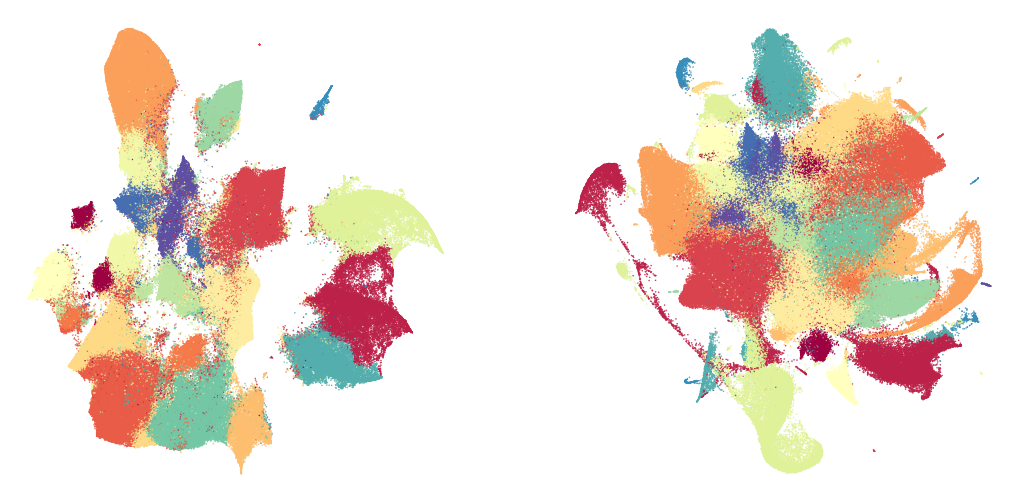

In [25]:
fig, ax = plt.subplots(1,2, figsize=(18,9));
ax[0].scatter(TSNE[:,0], TSNE[:,1], s=1, marker='.', c=labels, cmap='Spectral')
ax[0].axis('off');

ax[1].scatter(UMAP[:,0], UMAP[:,1], s=1, marker='.', c=labels, cmap='Spectral')
ax[1].axis('off');

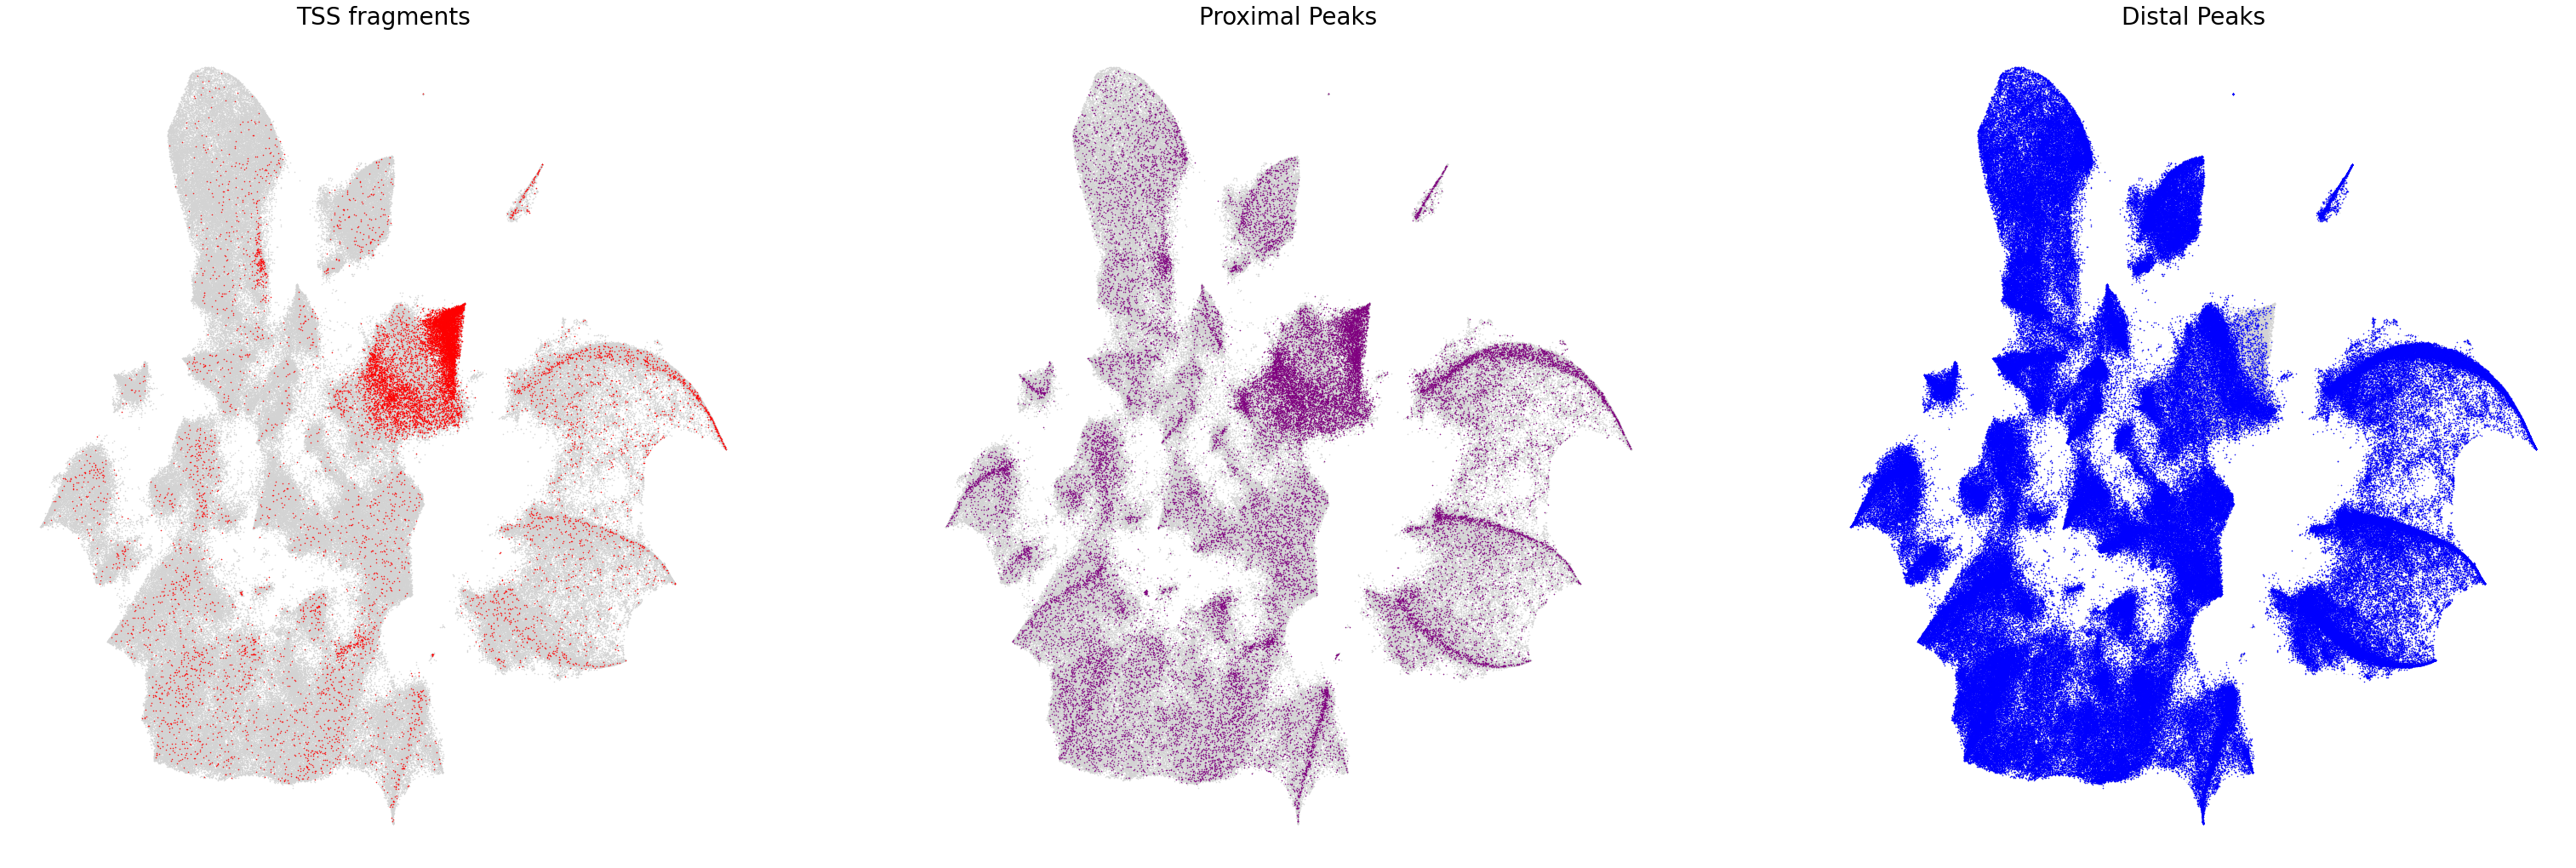

In [26]:
fig, ax = plt.subplots(1,3, figsize=(54,18));
    d = ds.ra['Distance to TSS'].astype(int)


ax[0].set_title('TSS fragments', fontsize=28)
ax[0].scatter(TSNE[:,0], TSNE[:,1], s=1, marker='.', c='lightgray')
ax[0].scatter(TSNE[d < 200,0], TSNE[d<200,1], s=1, marker='.', c='red')
ax[0].axis('off');

ax[1].set_title('Proximal Peaks', fontsize=28)
x = (d > 200) & (d < 2000)
ax[1].scatter(TSNE[:,0], TSNE[:,1], s=1, marker='.', c='lightgray')
ax[1].scatter(TSNE[x,0], TSNE[x,1], s=1, marker='.', c='purple')
ax[1].axis('off');

ax[2].set_title('Distal Peaks', fontsize=28)
ax[2].scatter(TSNE[:,0], TSNE[:,1], s=1, marker='.', c='lightgray')
ax[2].scatter(TSNE[d > 2000,0], TSNE[d>2000,1], s=1, marker='.', c='blue')
ax[2].axis('off');

## Data Ren

In [ ]:
file_dir = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/'
tissues = ['lung', 'liver']
# tissues = ['lung']

for tissue in tissues:
    files = os.listdir(file_dir)
    files = [f for f in files if f.split('_')[1]==tissue]
    for sample in np.unique([f.split('_')[2] for f in files]):
        mat_f = glob.glob(os.path.join(file_dir, f'*{tissue}_{sample}*.mtx.gz'))[0]
        peak_f = glob.glob(os.path.join(file_dir, f'*{tissue}_{sample}*features.txt.gz'))[0]
        bar_f = glob.glob(os.path.join(file_dir, f'*{tissue}_{sample}*barcodes.txt.gz'))[0]
        
#         mat = scipy.io.mmread(mat_f)
        peaks = pd.read_csv(peak_f, header=None, names = ['ID'])
        print(peaks.shape)
        x = peaks['ID'][10000].split(':')[1].split('-')
        print(peaks['ID'][10000])
        print(int(x[1])-int(x[0]))
        
#     mat = scipy.io.mmread(file_m)

In [ ]:
# data = pd.read_csv('/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/GSE165659_clustering_results.txt.gz', delimiter='\t')
data = pd.read_csv('/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/tmp/GSM5047855_liver_SM-A8WNZ_features.txt.gz', header=None, names = ['ID'])

In [ ]:
f_CRE = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/cCRE_Accessibility.tsv.gz'
f_loom = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Ren_peripherals/ALL_cCRE.agg.loom'
data = pd.read_csv(f_CRE, delimiter='\t', header=0, index_col=0)
IDs = np.array(data.index)
chrom, pos = np.array_split(np.array([x.split(':') for x in IDs]), 2, axis=1)
start, end = np.array_split(np.array([x[0].split('-') for x in pos.tolist()]), 2, axis=1)
Cell_type = np.array(data.columns)

In [ ]:
loompy.create(f_loom, layers=data.to_numpy(), row_attrs={'ID':IDs, 'Chr':chrom, 'Start':start, 'End':end}, col_attrs={'Cell_Type':Cell_type})

In [ ]:
with loompy.connect(f_loom) as ds:
#     plt.hist(ds[:,0], bins=30, range=(0,20))
    
    print(np.sum(ds[:,0]>1))
    print(np.sum(ds[:,0]))

## Data Ren 2

In [10]:
import csv
from itertools import chain
import gzip

import numpy as np
from twobitreader import TwoBitFile
from pathlib import Path

from tqdm import trange, tqdm

from Bio import SeqIO

import pandas as pd

import numpy as np

file_dir = '/proj/user/sten/DeepGBM/data'
dataset_path = os.path.join(file_dir, '4A_Raw_RPKM.tsv.gz')
genome_path = os.path.join(file_dir, "hg38.2bit")

# Figure out the size of the dataset
with gzip.open(dataset_path, mode='rt') as f:
    headers = f.readline()
    n_celltypes = len(headers.split("\t")) - 1
    start, end = f.readline().split("\t")[0].split(":")[1].split("-")
    enhancer_length = int(end) - int(start)
    n_enhancers = sum(1 for i in f) + 1  # Fast way to count lines in file

print(f"Loading {n_enhancers:,} enhancers of {enhancer_length} bp for {n_celltypes} cell types")
enhancer_names: List[str] = []
celltype_names: List[str] = []

hg38 = TwoBitFile(genome_path)

enhancer_chrs = []
enhancer_intervals = []
enhancer_onehot = np.zeros((n_enhancers, 4, enhancer_length), dtype="float32")
activity = np.zeros((n_enhancers, n_celltypes), dtype="float32")
ix = 0
logging.info(f"Loading data for {n_enhancers} enhancers")
with gzip.open(dataset_path, mode="rt") as f:
    for row in tqdm(csv.reader(f, delimiter="\t")):
        if ix == 0:
            celltype_names = row[1:]
        else:
            enhancer_names.append(row[0])
            ch, interval = row[0].split(":")
            a, b = interval.split("-")
            start = int(a)
            end = int(b)
            activity[ix - 2, :] = np.array(row[1:]).astype("float")
            enhancer_chrs.append(ch)
            enhancer_intervals.append((start, end))
            seq = hg38[ch][start:end].upper()
            onehot = np.vstack([
                [s == "A" for s in seq],
                [s == "C" for s in seq],
                [s == "G" for s in seq],
                [s == "T" for s in seq]
            ])
            enhancer_onehot[ix - 1, :, :] = onehot
        ix += 1
enhancer_names = np.array(enhancer_names).astype(object)
celltype_names = np.array(celltype_names).astype(object)

ModuleNotFoundError: No module named 'Bio'

## Data Payen

In [ ]:
fdir = '/proj/tmp/camiel/GSE158723/'
outdir = '/proj/loom/Payen_liver/'

files = os.listdir(fdir)
for sample in np.unique([f.split('_')[1] for f in files]):
    sample = sample.replace("-", "_")
    f_out = os.path.join(outdir, sample + '.loom')
    mat_f = glob.glob(os.path.join(fdir, f'*{sample}*.mtx.gz'))[0]
    genes_f = glob.glob(os.path.join(fdir, f'*{sample}*_genes.tsv.gz'))[0]
    bar_f = glob.glob(os.path.join(fdir, f'*{sample}*_barcodes.tsv.gz'))[0]
    
    genes = pd.read_csv(genes_f, delimiter='\t', header=None, names=['Accession','Gene']).to_dict('list')
    barcodes = pd.read_csv(bar_f, delimiter='\t', header=None, names=['barcode']).to_dict('list')
    mat = scipy.io.mmread(mat_f)
    
    loompy.create(f_out, mat, genes, barcodes)

In [ ]:
from cytograph.preprocessing import qc_functions

outdir = '/proj/loom/Payen_liver/'

for file in os.listdir(outdir):
    print(file)
    with loompy.connect(os.path.join(outdir, file)) as ds:
        print(ds.ca.keys())
        ds.attrs.passedQC = 1
        Donor = file.split('/')[-1].split('_')[0]
        print(Donor)
        ds.ca.Donor = np.repeat(Donor, repeats=ds.shape[1])
        ds.ca.SampleID = np.repeat(file.split('.')[0], repeats=ds.shape[1])
        ds.ca.Chemistry = np.repeat('v3', repeats=ds.shape[1])
        ds.ca.Age = np.repeat('?', repeats=ds.shape[1])
#         ds.ca.DoubletFinderScore = np.array(np.zeros(ds.shape[1]))
#         ds.ca.DoubletFinderFlag = np.array(np.zeros(ds.shape[1]))
        ds.ca.unspliced_ratio = np.array(np.ones(ds.shape[1]))l
        
#         (totals, genes) = ds.map([np.sum, np.count_nonzero], axis=1)
#         ds.ca["TotalUMI"] = totals
#         ds.ca["NGenes"] = genes
#         ds.attrs.MeanTotalUMI = np.mean(totals / ds.shape[1])
        
#         splits = [x.split('-') for  x in ds.ra.Gene]
#         mito = np.where([x[0] == 'MT' for  x in splits])[0]
        
#         ds.ca.MT_ratio = np.sum(ds[mito,:],  axis=0) / totals
        
        plt.hist(ds.ca.MT_ratio, alpha =.5, bins=30)
        
        low_MT = ds.ca.MT_ratio < 0.3


### Data Greenleaf

In [ ]:
# file_m = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.mtx'
# file_b = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt.gz'
# file_p = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.peaks.txt.gz'

# mat = scipy.io.mmread(file_m)

In [ ]:
fdir = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Greenleaf_immune'
file_m = os.path.join(fdir, 'GSE129785_scATAC-Hematopoiesis-All.mtx')
file_b = os.path.join(fdir, 'GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt.gz')
file_p = os.path.join(fdir, 'GSE129785_scATAC-Hematopoiesis-All.peaks.txt.gz')

mat = scipy.io.mmread(file_m)

In [ ]:
import pandas as pd
barcodes = pd.read_table(file_b)
peaks = pd.read_csv(file_p)


In [ ]:
col_attrs = {k: np.array(barcodes[k]) for k in barcodes}
del row_attrs

for x in peaks['Feature']:
    if 'row_attrs' not in locals():
        row_attrs = {}
        chrom, start, end = x.split('_')
        row_attrs['ID'] = [f'{chrom}:{start}-{end}']
        row_attrs['Chr'] = [chrom]
        row_attrs['Start'] = [start]
        row_attrs['End'] = [end]
    else:
        chrom, start, end = x.split('_')
        row_attrs['ID'].append(f'{chrom}:{start}-{end}')
        row_attrs['Chr'].append(chrom)
        row_attrs['Start'].append(start)
        row_attrs['End'].append(end)

In [ ]:
filename = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.loom'

loompy.create(filename, mat, row_attrs, col_attrs)

In [ ]:
from chromograph.peak_analysis.utils import *

filename = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.loom'
out_file = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.agg.loom'

agg_spec = {
    "Group": "tally",
    "Clusters": "first",
    "FRIP": "mean",
    "depth": "mean"
}

with loompy.connect(filename) as ds:
    ds.ca.Clusters = np.array([int(x.strip('Cluster')) for x in ds.ca.Clusters])
    ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:

        logging.info('Calculate coverage metrics')
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Call positive and negative peaks for every cluster
        dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)


In [ ]:
threshold = 1

out_file = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.agg.loom'
bed_file = '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg19.bed'
lifted_file = '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg38.bed'
unlifted = '/fish/other_tmp/camiel_tmp/Greenleaf/unlifted.bed'
with loompy.connect(out_file) as dsagg:
    logging.info(f'Shape {dsagg.shape}')
    Valids = []
    binary = dsagg['CPM'][:,:] > threshold
    ON = np.sum(binary[:,:], axis=1)
    Valids = ON > 0
    plt.figure()
    plt.title(f'Valid: {np.sum(Valids)}')
    plt.hist(ON[Valids], bins= 30)
    
with loompy.connect(out_file) as ds:
    enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)
    
subprocess.call(['/home/camiel/anaconda3/envs/DNA_tools/bin/liftOver', bed_file, '/datb/sl/camiel/scATAC/ref/hg19ToHg38.over.chain.gz', lifted_file, unlifted])
subprocess.call(['rm', unlifted])

### Corces Adult brain

In [ ]:
fdir = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Corces_adult_brain/summarized'
file_m = os.path.join(fdir, 'GSE147672_200324_Brain_scATAC_SummarizedExperiment_forGEO.mtx')
file_b = os.path.join(fdir, 'GSE147672_200324_Brain_scATAC_SummarizedExperiment_forGEO.barcodes.tsv.gz')
file_p = os.path.join(fdir, 'GSE147672_200324_Brain_scATAC_SummarizedExperiment_forGEO.peaks.tsv.gz')

mat = scipy.io.mmread(file_m).astype('int8')

In [ ]:
import pandas as pd
barcodes = pd.read_table(file_b)
peaks = pd.read_csv(file_p, '\t')

In [ ]:
col_attrs = {k: np.array(barcodes[k]) for k in barcodes}
if 'row_attrs' in locals():
    del row_attrs
    
for x in range(len(peaks)):
    if 'row_attrs' not in locals():
        row_attrs = {}
        chrom, start, end = peaks['seqnames'][x], peaks['start'][x], peaks['end'][x]
        row_attrs['ID'] = [f'{chrom}:{start}-{end}']
        row_attrs['Chr'] = [chrom]
        row_attrs['Start'] = [start]
        row_attrs['End'] = [end]
    else:
        chrom, start, end = peaks['seqnames'][x], peaks['start'][x], peaks['end'][x]
        row_attrs['ID'].append(f'{chrom}:{start}-{end}')
        row_attrs['Chr'].append(chrom)
        row_attrs['Start'].append(start)
        row_attrs['End'].append(end)

In [ ]:
filename = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/looms/Corces_peaks.loom'

loompy.create(filename, mat, row_attrs, col_attrs)

In [ ]:
with loompy.connect(filename) as ds:
    print(ds.ca.keys())

In [ ]:
from chromograph.peak_analysis.utils import *

out_file = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/looms/Corces_peaks.agg.loom'

agg_spec = {
    "Group": "tally",
    "Clusters": "first",
    "FRIP": "mean",
    "depth": "mean"
}

with loompy.connect(filename) as ds:
    ds.ca.Clusters = np.array([int(x.strip('Cluster')) for x in ds.ca.Clusters])
    ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:

        logging.info('Calculate coverage metrics')
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Call positive and negative peaks for every cluster
        dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)


In [ ]:
threshold = 1

bed_file = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/active_elements/Corces.hg38.bed'
with loompy.connect(out_file) as dsagg:
    logging.info(f'Shape {dsagg.shape}')
    Valids = []
    binary = dsagg['CPM'][:,:] > threshold
    ON = np.sum(binary[:,:], axis=1)
    Valids = ON > 0
    plt.figure()
    plt.title(f'Valid: {np.sum(Valids)}')
    plt.hist(ON[Valids], bins= 30)
    
with loompy.connect(out_file) as ds:
    enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)

## Lake data

In [ ]:
from scipy import sparse

for Tissue in ['Fcx1', 'Occ1', 'Cbh1']:

    logging.info(f'Start on tissue: {Tissue}')

    ## Recovering matrix from bam files
    f_dir = f'/fish/other_tmp/camiel_tmp/Lake/{Tissue}/bams'
    files = os.listdir(f_dir)

    barcodes = []
    Counts = {}
    peak_dict ={}

    with open(os.path.join(f_dir, files[0])) as fi:
        for i, line in enumerate(fi):
            if i > 0:
                peak_dict[line.split()[0]] = i - 1

    cnt = 0
    for f in files:
        b = f'{f.split(".")[0]}_{f.split(".")[2].split("_")[0]}'
        if b.endswith('H'):
            b = b.strip('H')
        barcodes.append(b)
        with open(os.path.join(f_dir, f)) as fi:
            for i, line in enumerate(fi):
                if i > 0:
                    fields = line.split()
                    count = int(fields[1])
                    if count > 0:
                        if b not in Counts:
                            Counts[b] = {fields[0]:fields[1]}
                        else:
                            Counts[b][fields[0]] = fields[1]
        cnt += 1
        if cnt%2000==0:
            logging.info(cnt)

    annot = {'ID': np.array([x for x in peak_dict])}

    c, s, e = [[],[],[]]
    for x in annot['ID']:
        chrom, loc = [k.split('-') for k in x.split(':')]
        c.append(chrom[0])
        s.append(loc[0])
        e.append(loc[1])

    annot['Chr'], annot['Start'], annot['End'] = [np.array(x) for x in [c, s, e]]

    meta = np.loadtxt('/fish/other_tmp/camiel_tmp/Lake/Lake_metadata.csv', delimiter=';', skiprows=1, dtype=str)
    cols = {'barcode':np.array(meta[:,0]), 'Shortname':np.array(meta[:,3]), 'Tissue':np.array(meta[:,4]), 'Clusters':np.array(meta[:,6]), 'Clusters2':np.array(meta[:,5])}

    logging.info("Generating Sparse matrix")
    col = []
    row = []
    v = []
    cix = 0
    IDs = []
    for cell in Counts:
        if cell in cols['barcode']:
            if len(Counts[cell]) > 0:
                for key in (Counts[cell]):
                    col.append(cix)
                    row.append(peak_dict[key])
                    v.append(np.int8(Counts[cell][key]))
                cix+=1
                IDs.append(cell)

    matrix = sparse.coo_matrix((v, (row,col)), shape=(len(peak_dict.keys()), cix)).tocsc()
    logging.info(f'Matrix has shape {matrix.shape} with {matrix.nnz} elements')

    Valid = [x in IDs for x in cols['barcode']]
    cols = {k: cols[k][Valid] for k in cols}
    cols['CellID'] = np.array([f'{cols["Shortname"][x]}:{cols["barcode"][x]}' for x in range(len(cols['barcode']))])
    ID_dict = {k: v for v, k in enumerate(IDs)}
    reorder = [ID_dict[k] for k in cols['barcode']]
    cols = {k: cols[k][reorder] for k in cols}

    out_file = f'/fish/other_tmp/camiel_tmp/Lake/{Tissue}/Lake_{Tissue}.loom'
    loompy.create(filename=out_file, 
                  layers=matrix, 
                  row_attrs=annot, 
                  col_attrs=cols)
    logging.info(f'Saved file as {out_file}')

In [ ]:
files = [os.path.join('/fish/other_tmp/camiel_tmp/Lake/', Tissue, f'Lake_{Tissue}.loom') for Tissue in ['Fcx1', 'Occ1', 'Cbh1']]
merge_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.loom'

loompy.combine_faster(files, merge_file)

In [ ]:
out_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.agg.loom'
merge_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.loom'
agg_spec = {
    "Group": "Tissue",
    "Clusters": "first",
    "ClusterNames": "first",
    "Shortname": "tally"
}

with loompy.connect(merge_file) as ds:
    ds.ca.ClusterNames = ds.ca.Clusters
    enum = {k:v for v, k in enumerate(np.unique(ds.ca.ClusterNames))}
    ds.ca.Clusters = np.array([enum[x] for x in ds.ca.ClusterNames])
    ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:

        logging.info('Calculate coverage metrics')
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Call positive and negative peaks for every cluster
        dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)


In [ ]:
threshold = 1

out_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.agg.loom'
bed_file = '/fish/other_tmp/camiel_tmp/Lake/active_elements.hg38.bed'
with loompy.connect(out_file) as dsagg:
    logging.info(f'Shape {dsagg.shape}')
    Valids = []
    binary = dsagg['CPM'][:,:] > threshold
    ON = np.sum(binary[:,:], axis=1)
    Valids = ON > 0
    plt.figure()
    plt.title(f'Valid: {np.sum(Valids)}')
    plt.hist(ON[Valids], bins= 30)
    
with loompy.connect(out_file) as ds:
    enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)